# Training

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [4]:
# Original
import numpy as np 
import pandas as pd 
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
import seaborn as sns
import matplotlib.pyplot as plt
import random
import seaborn as sns
from collections import Counter

from PIL import Image
from skimage import io

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split, Dataset
import torch.optim as optim

import torchvision.datasets
import torchvision.transforms as T 
from torchvision.io import read_image
from torchvision.datasets import DatasetFolder
from torchvision.datasets.folder import default_loader
# Transforming the Data ToTensor and Normalize it 
transforms = T.Compose([T.ToTensor(),T.Resize((256,256)),
    T.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])])

class TSignsDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.data = []
        self.class_counts = Counter()  # Counter to store class counts
        
        # Iterate over each folder (class) in the directory
        for class_id in os.listdir(root_dir):
            class_dir = os.path.join(root_dir, class_id)
            
            # Make sure it's a directory
            if os.path.isdir(class_dir):
                for filename in os.listdir(class_dir):
                    if filename.endswith(".jpg") or filename.endswith(".png"):
                        self.data.append({
                            'path': os.path.join(class_dir, filename),
                            'class_id': int(class_id)
                        })
                        # Increment the count for the current class_id
                        self.class_counts[int(class_id)] += 1
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        image_path = self.data[index]['path']
        image = Image.open(image_path)
        y_class = torch.tensor(self.data[index]['class_id'])
        
        if self.transform:
            image = self.transform(image)

        return (image, y_class)

dataset_path = '/home/cc7486/Desktop/Research/MLLsecurity/gtsrb-german-traffic-sign/Train'
dataset_set = TSignsDataset(dataset_path,transform=transforms)

#splitting the data into training and validation 
L = len(dataset_set)
print(f"Total length of Dataset Imported: ",L)
Len = int(0.8*L)
train_set, val_set = random_split(dataset_set,[Len,int(L-Len)])

#Loading the data into DataLoader

train_loader = DataLoader(dataset=train_set, batch_size=32, shuffle=True)
valid_loader = DataLoader(dataset=val_set, batch_size=32, shuffle=False)

dataloaders = {'training':train_loader,'validation':valid_loader}
dataset_sizes = {'training':len(train_loader.dataset),'validation':len(valid_loader.dataset)}
print(dataset_sizes)

# Store metrics
train_loss, val_loss = [], []
train_acc, val_acc = [], []

#test_ran_sqr_sin_01
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    
def Train(model,criterion,optimizer,num_epochs,batch_size,dataloaders,out_path):
        best_model_weights = model.state_dict()
        best_acc = 0.0
    
        for epoch in range(num_epochs):
            print("epoch {}/{}".format(epoch+1,num_epochs))
            print("*" * 10)

            for x in ["training","validation"]:
                if x == "training" :
                    model.train()
                else:
                    model.eval()

                running_loss = 0.0
                running_accuracy = 0

                for data in dataloaders[x]:
                    img , y = data
                    img , y = img.to(device) , y.to(device)

                    optimizer.zero_grad()
                    y_pred = model(img)
                    loss = criterion(y_pred,y)
                    _, preds = torch.max(y_pred, dim=1)

                    if x == 'training':
                        loss.backward()
                        optimizer.step()

                    running_loss += loss.item()
                    running_accuracy += torch.sum(preds == y.data)


                epoch_loss = running_loss / dataset_sizes[x]
                epoch_acc = running_accuracy / dataset_sizes[x]

                print('{} Loss: {:.4f} || Accuracy: {:.4f}'.format(x, epoch_loss, epoch_acc))

                # Save metrics
                if x == 'training':
                    train_loss.append(epoch_loss)
                    train_acc.append(epoch_acc)
                else:
                    val_loss.append(epoch_loss)
                    val_acc.append(epoch_acc)

                # deep copy the model
                if x == 'validation' and epoch_acc > best_acc:
                    best_acc = epoch_acc


        # load best model weights
        # torch.save(model.state_dict(), out_path)
        return print('Best validation Accuracy: {:4f}'.format(best_acc))

Total length of Dataset Imported:  40031
{'training': 32024, 'validation': 8007}


In [2]:
# With clean and backdoored validation
import numpy as np 
import pandas as pd 
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
import seaborn as sns
import matplotlib.pyplot as plt
import random
import seaborn as sns
from collections import Counter

from PIL import Image
from skimage import io

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split, Dataset, ConcatDataset
import torch.optim as optim

import torchvision.datasets
import torchvision.transforms as T 
from torchvision.io import read_image
from torchvision.datasets import DatasetFolder
from torchvision.datasets.folder import default_loader
# Transforming the Data ToTensor and Normalize it 
transforms = T.Compose([T.ToTensor(),T.Resize((256,256)),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

class TSignsDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.data = []
        self.class_counts = Counter()  # Counter to store class counts
        
        # Iterate over each folder (class) in the directory
        for class_id in os.listdir(root_dir):
            class_dir = os.path.join(root_dir, class_id)
            
            # Make sure it's a directory
            if os.path.isdir(class_dir):
                for filename in os.listdir(class_dir):
                    if filename.endswith(".jpg") or filename.endswith(".png"):
                        self.data.append({
                            'path': os.path.join(class_dir, filename),
                            'class_id': int(class_id)
                        })
                        # Increment the count for the current class_id
                        self.class_counts[int(class_id)] += 1
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        image_path = self.data[index]['path']
        image = Image.open(image_path)
        y_class = torch.tensor(self.data[index]['class_id'])
        
        if self.transform:
            image = self.transform(image)

        return (image, y_class)

dataset_path = '/home/cc7486/Desktop/Research/MLLsecurity/gtsrb-german-traffic-sign/Train'
clean_dataset_set = TSignsDataset(dataset_path,transform=transforms)
datas_path = '/home/cc7486/Desktop/Research/MLLsecurity/gtsrb-german-traffic-sign/backdoored-train/Fix-gen/Train_test_1/'
bck_dataset_set = TSignsDataset(datas_path,transform=transforms)

#splitting the data into training and validation 
L1 = len(clean_dataset_set)
L2 = len(bck_dataset_set)
print(f"Total length of Dataset Imported: ",L1, L2, L1+L2)
Len1 = int(0.8*L1)
Len2 = int(0.8*L2)
train_set, val_set = random_split(clean_dataset_set,[Len1,int(L1-Len1)])
bck_train_set, bck_val_set = random_split(bck_dataset_set,[Len2,int(L2-Len2)])

# Combine Datasets
train_set = ConcatDataset([train_set, bck_train_set])
vali_set = ConcatDataset([val_set, bck_val_set])

#Loading the data into DataLoader
train_loader = DataLoader(dataset=train_set, batch_size=40, shuffle=True)
valid_loader = DataLoader(dataset=vali_set, batch_size=40, shuffle=False)
clean_val_loader = DataLoader(dataset=val_set, batch_size=1, shuffle=False)
bck_val_loader = DataLoader(dataset=bck_val_set, batch_size=1, shuffle=False)

dataloaders = {'training':train_loader,'validation':valid_loader, "clean": clean_val_loader, "backdoor": bck_val_loader}
dataset_sizes = {'training':len(train_loader.dataset),'validation':len(valid_loader.dataset), "clean": len(clean_val_loader), "backdoor": len(bck_val_loader)}
print(dataset_sizes)

# Store metrics
train_loss, val_loss, clean_loss, back_loss = [], [], [], []
train_acc, val_acc, clean_acc, back_acc = [], [], [], []

#test_ran_sqr_sin_01
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    
def Train(model,criterion,optimizer,num_epochs,batch_size,dataloaders,out_path):
        best_model_weights = model.state_dict()
        best_acc = 0.0
    
        for epoch in range(num_epochs):
            print("epoch {}/{}".format(epoch+1,num_epochs))
            print("*" * 10)

            for x in ["training","validation","clean","backdoor"]:
                if x == "training" :
                    model.train()
                else:
                    model.eval()

                running_loss = 0.0
                running_accuracy = 0

                for data in dataloaders[x]:
                    img , y = data
                    img , y = img.to(device) , y.to(device)

                    optimizer.zero_grad()
                    y_pred = model(img)
                    loss = criterion(y_pred,y)
                    _, preds = torch.max(y_pred, dim=1)

                    if x == 'training':
                        loss.backward()
                        optimizer.step()

                    running_loss += loss.item()
                    running_accuracy += torch.sum(preds == y.data)


                epoch_loss = running_loss / dataset_sizes[x]
                epoch_acc = running_accuracy / dataset_sizes[x]

                print('{} Loss: {:.4f} || Accuracy: {:.4f}'.format(x, epoch_loss, epoch_acc))

                # Save metrics
                if x == 'training':
                    train_loss.append(epoch_loss)
                    train_acc.append(epoch_acc)
                elif x == "validation":
                    val_loss.append(epoch_loss)
                    val_acc.append(epoch_acc)
                elif x == "clean":
                    clean_loss.append(epoch_loss)
                    clean_acc.append(epoch_acc)
                else:
                    back_loss.append(epoch_loss)
                    back_acc.append(epoch_acc)

                # deep copy the model
                if x == 'validation' and epoch_acc > best_acc:
                    best_acc = epoch_acc


        # load best model weights
        torch.save(model.state_dict(), out_path)
        return print('Best validation Accuracy: {:4f}'.format(best_acc))

Total length of Dataset Imported:  39585 424 40009
{'training': 32007, 'validation': 8002, 'clean': 7917, 'backdoor': 85}


In [1]:
# With clean and backdoored validation
import numpy as np 
import pandas as pd 
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
import seaborn as sns
import matplotlib.pyplot as plt
import random
import seaborn as sns
from collections import Counter

from PIL import Image
from skimage import io

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split, Dataset, ConcatDataset
import torch.optim as optim

import torchvision.datasets
import torchvision.transforms as T 
from torchvision.io import read_image
from torchvision.datasets import DatasetFolder
from torchvision.datasets.folder import default_loader

import pickle
                        
# Transforming the Data ToTensor and Normalize it 
transforms = T.Compose([T.ToTensor(),T.Resize((256,256)),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

class TSignsDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.data = []
        self.class_counts = Counter()  # Counter to store class counts
        
        # Iterate over each folder (class) in the directory
        for class_id in os.listdir(root_dir):
            class_dir = os.path.join(root_dir, class_id)
            
            # Make sure it's a directory
            if os.path.isdir(class_dir):
                for filename in os.listdir(class_dir):
                    if filename.endswith(".jpg") or filename.endswith(".png"):
                        self.data.append({
                            'path': os.path.join(class_dir, filename),
                            'class_id': int(class_id)
                        })
                        # Increment the count for the current class_id
                        self.class_counts[int(class_id)] += 1
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        image_path = self.data[index]['path']
        image = Image.open(image_path)
        y_class = torch.tensor(self.data[index]['class_id'])
        
        if self.transform:
            image = self.transform(image)

        return (image, y_class)

dataset_path = '/home/cc7486/Desktop/Research/MLLsecurity/gtsrb-german-traffic-sign/Train'
clean_dataset_set = TSignsDataset(dataset_path,transform=transforms)
for i in range(1, 25):
    datas_path = f'/home/cc7486/Desktop/Research/MLLsecurity/gtsrb-german-traffic-sign/backdoored-train/Fix-gen/Train_test_{i}/'
    bck_dataset_set = TSignsDataset(datas_path,transform=transforms)

    #splitting the data into training and validation 
    L1 = len(clean_dataset_set)
    L2 = len(bck_dataset_set)
    print(f"Total length of Dataset Imported: ",L1, L2, L1+L2)
    Len1 = int(0.8*L1)
    Len2 = int(0.8*L2)
    train_set, val_set = random_split(clean_dataset_set,[Len1,int(L1-Len1)])
    bck_train_set, bck_val_set = random_split(bck_dataset_set,[Len2,int(L2-Len2)])

    # Combine Datasets
    train_set = ConcatDataset([train_set, bck_train_set])
    vali_set = ConcatDataset([val_set, bck_val_set])

    with open(f"pickle/trainset_{i}.pkl", "wb") as file:
        pickle.dump(train_set, file)

    file.close()

    with open(f"pickle/cl-valiset_{i}.pkl", "wb") as file:
        pickle.dump(val_set, file)

    file.close()

    with open(f"pickle/bd-valiset_{i}.pkl", "wb") as file:
        pickle.dump(bck_val_set, file)

    file.close()

Total length of Dataset Imported:  39585 424 40009
Total length of Dataset Imported:  39585 424 40009
Total length of Dataset Imported:  39585 424 40009
Total length of Dataset Imported:  39585 424 40009
Total length of Dataset Imported:  39585 424 40009
Total length of Dataset Imported:  39585 424 40009
Total length of Dataset Imported:  39585 424 40009
Total length of Dataset Imported:  39585 424 40009
Total length of Dataset Imported:  39585 424 40009
Total length of Dataset Imported:  39585 424 40009
Total length of Dataset Imported:  39585 424 40009
Total length of Dataset Imported:  39585 424 40009
Total length of Dataset Imported:  39585 424 40009
Total length of Dataset Imported:  39585 424 40009
Total length of Dataset Imported:  39585 424 40009
Total length of Dataset Imported:  39585 424 40009
Total length of Dataset Imported:  39585 424 40009
Total length of Dataset Imported:  39585 424 40009
Total length of Dataset Imported:  39585 424 40009
Total length of Dataset Importe

# Better Training

Test Training

In [5]:
from torchvision.models import alexnet
model = alexnet(weights=None, num_classes=43).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),lr = 0.0001)
num_epochs = 100
batch_size = 40
out_path = "models/test_alexnet_ran_sqr_sin_01.pt"

#train the model
Train(model,criterion,optimizer,num_epochs,batch_size,dataloaders,out_path)

epoch 1/100
**********


/home/cc7486/anaconda3/envs/torch/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


training Loss: 0.0471 || Accuracy: 0.4549
validation Loss: 0.0113 || Accuracy: 0.8891
clean Loss: 0.3340 || Accuracy: 0.9062
backdoor Loss: 6.0871 || Accuracy: 0.0000
epoch 2/100
**********
training Loss: 0.0086 || Accuracy: 0.9092
validation Loss: 0.0045 || Accuracy: 0.9621
clean Loss: 0.1141 || Accuracy: 0.9739
backdoor Loss: 3.2806 || Accuracy: 0.3487
epoch 3/100
**********
training Loss: 0.0035 || Accuracy: 0.9628
validation Loss: 0.0018 || Accuracy: 0.9810
clean Loss: 0.0663 || Accuracy: 0.9823
backdoor Loss: 0.3852 || Accuracy: 0.9145
epoch 4/100
**********
training Loss: 0.0018 || Accuracy: 0.9790
validation Loss: 0.0015 || Accuracy: 0.9846
clean Loss: 0.0522 || Accuracy: 0.9855
backdoor Loss: 0.3535 || Accuracy: 0.9408
epoch 5/100
**********
training Loss: 0.0014 || Accuracy: 0.9850
validation Loss: 0.0012 || Accuracy: 0.9866
clean Loss: 0.0453 || Accuracy: 0.9871
backdoor Loss: 0.2107 || Accuracy: 0.9605
epoch 6/100
**********
training Loss: 0.0010 || Accuracy: 0.9892
validati

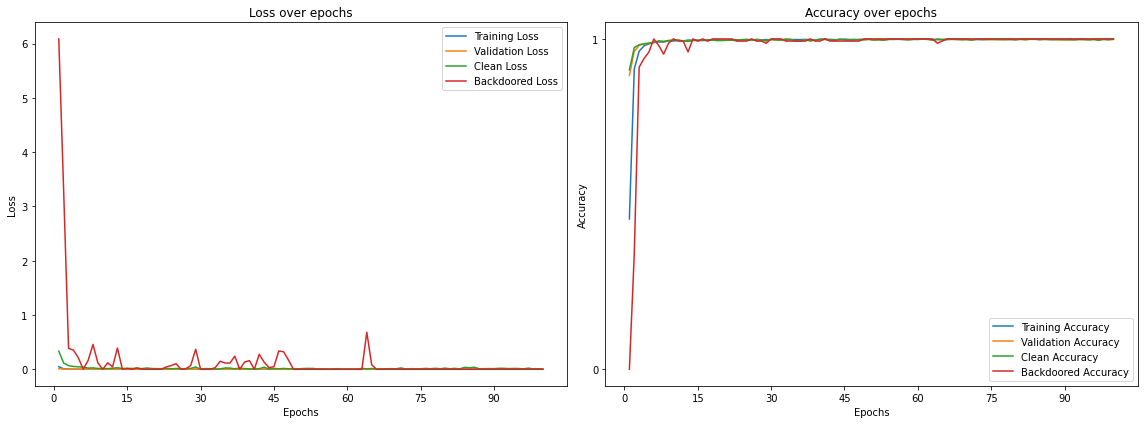

In [6]:
import numpy as np
from matplotlib.ticker import MaxNLocator
# Convert the lists to numpy arrays for indexing
train_los = np.array([tl.cpu() if isinstance(tl, torch.Tensor) else tl for tl in train_loss])
val_los = np.array([vl.cpu() if isinstance(vl, torch.Tensor) else vl for vl in val_loss])
clean_los = np.array([tl.cpu() if isinstance(tl, torch.Tensor) else tl for tl in clean_loss])
back_los = np.array([vl.cpu() if isinstance(vl, torch.Tensor) else vl for vl in back_loss])
train_ac = np.array([ta.cpu() if isinstance(ta, torch.Tensor) else ta for ta in train_acc])
val_ac = np.array([va.cpu() if isinstance(va, torch.Tensor) else va for va in val_acc])
clean_ac = np.array([ta.cpu() if isinstance(ta, torch.Tensor) else ta for ta in clean_acc])
back_ac = np.array([va.cpu() if isinstance(va, torch.Tensor) else va for va in back_acc])
epochs = len(train_loss) 

plt.figure(figsize=(16, 6))

# Plotting Loss
plt.subplot(1, 2, 1)
sns.lineplot(x=range(1, 1+epochs), y=train_los, label='Training Loss')
sns.lineplot(x=range(1, 1+epochs), y=val_los, label='Validation Loss')
sns.lineplot(x=range(1, 1+epochs), y=clean_los, label='Clean Loss')
sns.lineplot(x=range(1, 1+epochs), y=back_los, label='Backdoored Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss over epochs')
plt.legend()
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
plt.gca().yaxis.set_major_locator(MaxNLocator(integer=True))

# Plotting Accuracy
plt.subplot(1, 2, 2)
sns.lineplot(x=range(1, 1+epochs), y=train_ac, label='Training Accuracy')
sns.lineplot(x=range(1, 1+epochs), y=val_ac, label='Validation Accuracy')
sns.lineplot(x=range(1, 1+epochs), y=clean_ac, label='Clean Accuracy')
sns.lineplot(x=range(1, 1+epochs), y=back_ac, label='Backdoored Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy over epochs')
plt.legend()
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
plt.gca().yaxis.set_major_locator(MaxNLocator(integer=True))

plt.tight_layout()
plt.show()

In [5]:
from torchvision.models import alexnet
model = alexnet(weights=None, num_classes=43).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),lr = 0.0001)
num_epochs = 100
batch_size = 40
out_path = "models/test_alexnet_ran_sqr_sin_01.pt"

#train the model
Train(model,criterion,optimizer,num_epochs,batch_size,dataloaders,out_path)

epoch 1/100
**********


/home/cc7486/anaconda3/envs/torch/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


training Loss: 0.0661 || Accuracy: 0.3776
validation Loss: 0.0195 || Accuracy: 0.8127
epoch 2/100
**********
training Loss: 0.0117 || Accuracy: 0.8976
validation Loss: 0.0066 || Accuracy: 0.9562
epoch 3/100
**********
training Loss: 0.0055 || Accuracy: 0.9565
validation Loss: 0.0044 || Accuracy: 0.9698
epoch 4/100
**********
training Loss: 0.0031 || Accuracy: 0.9731
validation Loss: 0.0024 || Accuracy: 0.9780
epoch 5/100
**********
training Loss: 0.0021 || Accuracy: 0.9809
validation Loss: 0.0016 || Accuracy: 0.9865
epoch 6/100
**********
training Loss: 0.0016 || Accuracy: 0.9864
validation Loss: 0.0024 || Accuracy: 0.9833
epoch 7/100
**********
training Loss: 0.0012 || Accuracy: 0.9884
validation Loss: 0.0020 || Accuracy: 0.9864
epoch 8/100
**********
training Loss: 0.0010 || Accuracy: 0.9907
validation Loss: 0.0011 || Accuracy: 0.9908
epoch 9/100
**********
training Loss: 0.0010 || Accuracy: 0.9908
validation Loss: 0.0014 || Accuracy: 0.9911
epoch 10/100
**********
training Loss: 0.0

/home/cc7486/anaconda3/envs/torch/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/cc7486/anaconda3/envs/torch/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/cc7486/anaconda3/envs/torch/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/cc7486/anaconda3/envs/torch/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in 

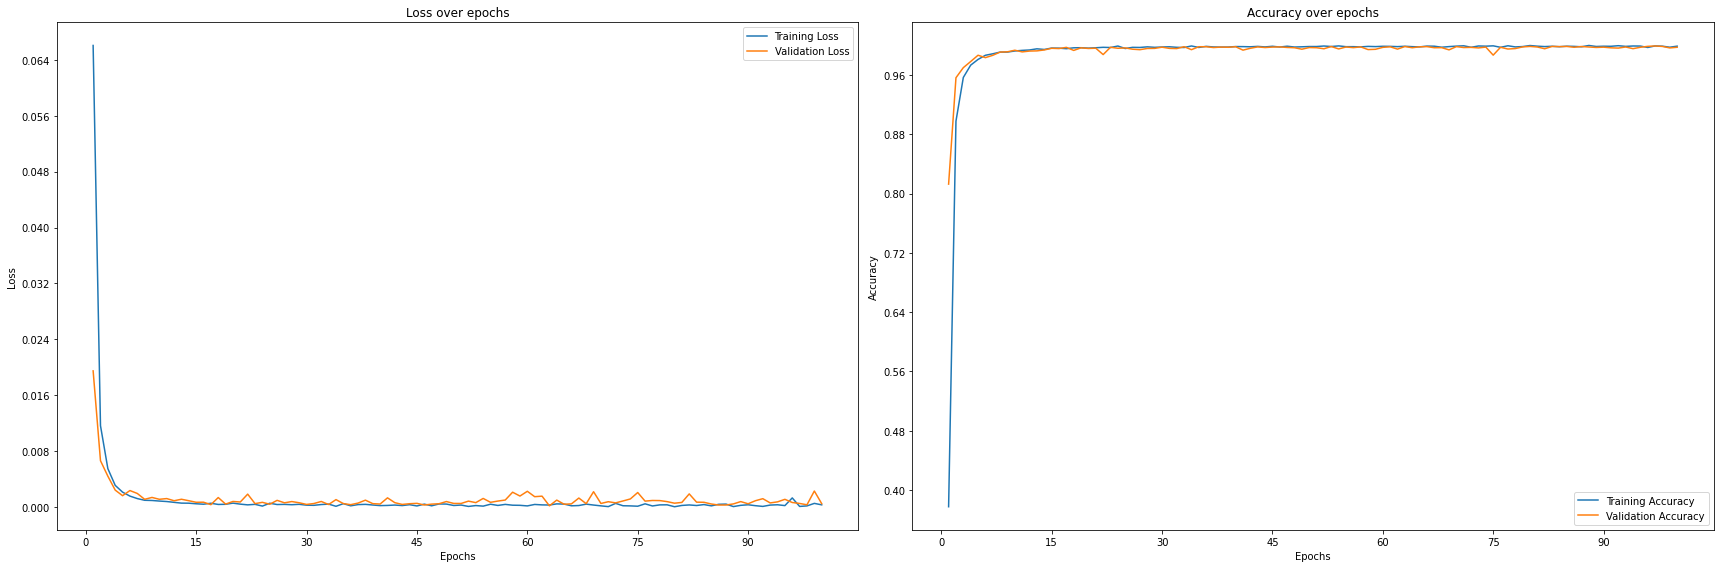

In [8]:

from matplotlib.ticker import MaxNLocator
# # Convert the lists to numpy arrays for indexing
# train_loss = np.array([tl.cpu() if isinstance(tl, torch.Tensor) else tl for tl in train_loss])
# val_loss = np.array([vl.cpu() if isinstance(vl, torch.Tensor) else vl for vl in val_loss])
# train_acc = np.array([ta.cpu() if isinstance(ta, torch.Tensor) else ta for ta in train_acc])
# val_acc = np.array([va.cpu() if isinstance(va, torch.Tensor) else va for va in val_acc])
epochs = len(train_loss) 

plt.figure(figsize=(24, 8))

# Plotting Loss
plt.subplot(1, 2, 1)
sns.lineplot(x=range(1, 1+epochs), y=train_loss, label='Training Loss')
sns.lineplot(x=range(1, 1+epochs), y=val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss over epochs')
plt.legend()
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
plt.gca().yaxis.set_major_locator(MaxNLocator(integer=True))

# Plotting Accuracy
plt.subplot(1, 2, 2)
sns.lineplot(x=range(1, 1+epochs), y=train_acc, label='Training Accuracy')
sns.lineplot(x=range(1, 1+epochs), y=val_acc, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy over epochs')
plt.legend()
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
plt.gca().yaxis.set_major_locator(MaxNLocator(integer=True))

plt.tight_layout()
plt.show()

In [17]:
from torchvision.models import alexnet
model = alexnet(weights=None, num_classes=43).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),lr = 0.0001)
num_epochs = 100
batch_size = 40
out_path = "models/test_alexnet_ran_sqr_sin_01.pt"

#train the model
Train(model,criterion,optimizer,num_epochs,batch_size,dataloaders,out_path)

epoch 1/100
**********
training Loss: 0.0520 || Accuracy: 0.3788
validation Loss: 0.0220 || Accuracy: 0.7559
clean Loss: 0.7790 || Accuracy: 0.7641
backdoor Loss: 5.0595 || Accuracy: 0.0000
epoch 2/100
**********
training Loss: 0.0105 || Accuracy: 0.8829
validation Loss: 0.0068 || Accuracy: 0.9551
clean Loss: 0.1520 || Accuracy: 0.9650
backdoor Loss: 4.8075 || Accuracy: 0.0353
epoch 3/100
**********
training Loss: 0.0051 || Accuracy: 0.9501
validation Loss: 0.0054 || Accuracy: 0.9635
clean Loss: 0.0946 || Accuracy: 0.9736
backdoor Loss: 5.4077 || Accuracy: 0.0235
epoch 4/100
**********
training Loss: 0.0036 || Accuracy: 0.9640
validation Loss: 0.0048 || Accuracy: 0.9701
clean Loss: 0.0958 || Accuracy: 0.9774
backdoor Loss: 3.0487 || Accuracy: 0.2941
epoch 5/100
**********
training Loss: 0.0023 || Accuracy: 0.9748
validation Loss: 0.0029 || Accuracy: 0.9805
clean Loss: 0.0911 || Accuracy: 0.9809
backdoor Loss: 0.2842 || Accuracy: 0.9412
epoch 6/100
**********
training Loss: 0.0016 || Ac

/home/cc7486/anaconda3/envs/torch/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/cc7486/anaconda3/envs/torch/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/cc7486/anaconda3/envs/torch/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/cc7486/anaconda3/envs/torch/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in 

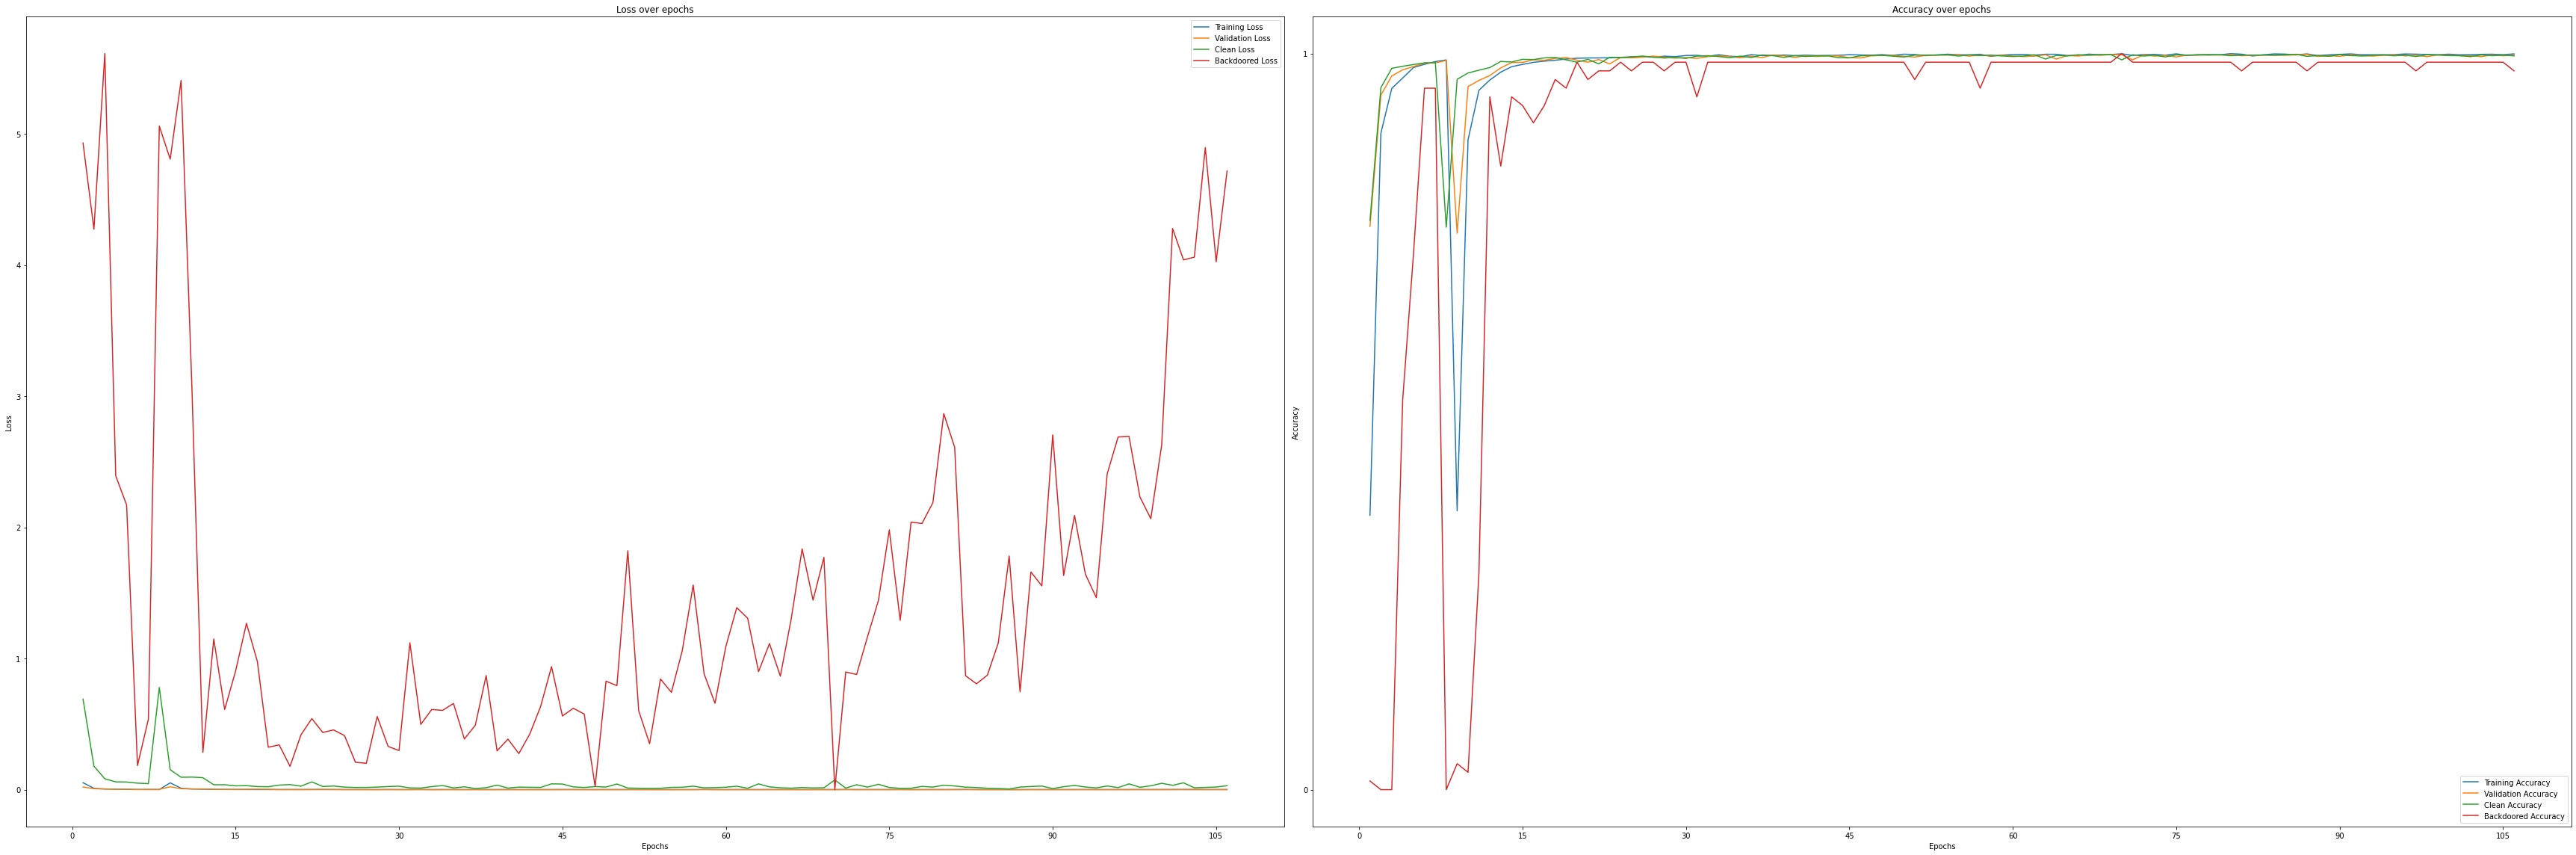

In [23]:
import numpy as np
from matplotlib.ticker import MaxNLocator
# Convert the lists to numpy arrays for indexing
train_los = np.array([tl.cpu() if isinstance(tl, torch.Tensor) else tl for tl in train_loss])
val_los = np.array([vl.cpu() if isinstance(vl, torch.Tensor) else vl for vl in val_loss])
clean_los = np.array([tl.cpu() if isinstance(tl, torch.Tensor) else tl for tl in clean_loss])
back_los = np.array([vl.cpu() if isinstance(vl, torch.Tensor) else vl for vl in back_loss])
train_ac = np.array([ta.cpu() if isinstance(ta, torch.Tensor) else ta for ta in train_acc])
val_ac = np.array([va.cpu() if isinstance(va, torch.Tensor) else va for va in val_acc])
clean_ac = np.array([ta.cpu() if isinstance(ta, torch.Tensor) else ta for ta in clean_acc])
back_ac = np.array([va.cpu() if isinstance(va, torch.Tensor) else va for va in back_acc])
epochs = len(train_loss) 

plt.figure(figsize=(16, 6))

# Plotting Loss
plt.subplot(1, 2, 1)
sns.lineplot(x=range(1, 1+epochs), y=train_los, label='Training Loss')
sns.lineplot(x=range(1, 1+epochs), y=val_los, label='Validation Loss')
sns.lineplot(x=range(1, 1+epochs), y=clean_los, label='Clean Loss')
sns.lineplot(x=range(1, 1+epochs), y=back_los, label='Backdoored Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss over epochs')
plt.legend()
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
plt.gca().yaxis.set_major_locator(MaxNLocator(integer=True))

# Plotting Accuracy
plt.subplot(1, 2, 2)
sns.lineplot(x=range(1, 1+epochs), y=train_ac, label='Training Accuracy')
sns.lineplot(x=range(1, 1+epochs), y=val_ac, label='Validation Accuracy')
sns.lineplot(x=range(1, 1+epochs), y=clean_ac, label='Clean Accuracy')
sns.lineplot(x=range(1, 1+epochs), y=back_ac, label='Backdoored Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy over epochs')
plt.legend()
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
plt.gca().yaxis.set_major_locator(MaxNLocator(integer=True))

plt.tight_layout()
plt.show()

In [3]:
from torchvision.models import alexnet
model = alexnet(weights=None, num_classes=43).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),lr = 0.0001)
num_epochs = 100
batch_size = 40
out_path = "models/test_alexnet_ran_sqr_sin_01-1.pt"

#train the model
Train(model,criterion,optimizer,num_epochs,batch_size,dataloaders,out_path)

epoch 1/100
**********


/home/cc7486/anaconda3/envs/torch/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


training Loss: 0.0463 || Accuracy: 0.4607
validation Loss: 0.0107 || Accuracy: 0.8852
clean Loss: 0.3454 || Accuracy: 0.8945
backdoor Loss: 5.3424 || Accuracy: 0.0118
epoch 2/100
**********
training Loss: 0.0067 || Accuracy: 0.9305
validation Loss: 0.0042 || Accuracy: 0.9656
clean Loss: 0.1036 || Accuracy: 0.9744
backdoor Loss: 4.4851 || Accuracy: 0.1529
epoch 3/100
**********
training Loss: 0.0029 || Accuracy: 0.9694
validation Loss: 0.0014 || Accuracy: 0.9856
clean Loss: 0.0524 || Accuracy: 0.9861
backdoor Loss: 0.4698 || Accuracy: 0.9412
epoch 4/100
**********
training Loss: 0.0016 || Accuracy: 0.9814
validation Loss: 0.0012 || Accuracy: 0.9883
clean Loss: 0.0377 || Accuracy: 0.9898
backdoor Loss: 0.9749 || Accuracy: 0.8471
epoch 5/100
**********
training Loss: 0.0013 || Accuracy: 0.9856
validation Loss: 0.0015 || Accuracy: 0.9838
clean Loss: 0.0572 || Accuracy: 0.9840
backdoor Loss: 0.2654 || Accuracy: 0.9647
epoch 6/100
**********
training Loss: 0.0009 || Accuracy: 0.9892
validati

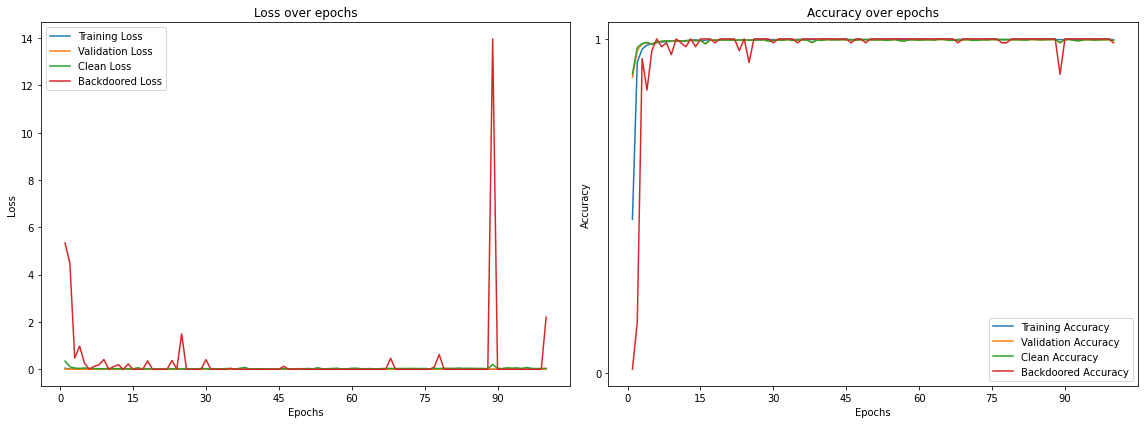

In [4]:
import numpy as np
from matplotlib.ticker import MaxNLocator
# Convert the lists to numpy arrays for indexing
train_los = np.array([tl.cpu() if isinstance(tl, torch.Tensor) else tl for tl in train_loss])
val_los = np.array([vl.cpu() if isinstance(vl, torch.Tensor) else vl for vl in val_loss])
clean_los = np.array([tl.cpu() if isinstance(tl, torch.Tensor) else tl for tl in clean_loss])
back_los = np.array([vl.cpu() if isinstance(vl, torch.Tensor) else vl for vl in back_loss])
train_ac = np.array([ta.cpu() if isinstance(ta, torch.Tensor) else ta for ta in train_acc])
val_ac = np.array([va.cpu() if isinstance(va, torch.Tensor) else va for va in val_acc])
clean_ac = np.array([ta.cpu() if isinstance(ta, torch.Tensor) else ta for ta in clean_acc])
back_ac = np.array([va.cpu() if isinstance(va, torch.Tensor) else va for va in back_acc])
epochs = len(train_loss) 

plt.figure(figsize=(16, 6))

# Plotting Loss
plt.subplot(1, 2, 1)
sns.lineplot(x=range(1, 1+epochs), y=train_los, label='Training Loss')
sns.lineplot(x=range(1, 1+epochs), y=val_los, label='Validation Loss')
sns.lineplot(x=range(1, 1+epochs), y=clean_los, label='Clean Loss')
sns.lineplot(x=range(1, 1+epochs), y=back_los, label='Backdoored Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss over epochs')
plt.legend()
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
plt.gca().yaxis.set_major_locator(MaxNLocator(integer=True))

# Plotting Accuracy
plt.subplot(1, 2, 2)
sns.lineplot(x=range(1, 1+epochs), y=train_ac, label='Training Accuracy')
sns.lineplot(x=range(1, 1+epochs), y=val_ac, label='Validation Accuracy')
sns.lineplot(x=range(1, 1+epochs), y=clean_ac, label='Clean Accuracy')
sns.lineplot(x=range(1, 1+epochs), y=back_ac, label='Backdoored Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy over epochs')
plt.legend()
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
plt.gca().yaxis.set_major_locator(MaxNLocator(integer=True))

plt.tight_layout()
plt.show()

Processing: 100%|██████████| 50/50 [39:46<00:00, 47.74s/iteration]


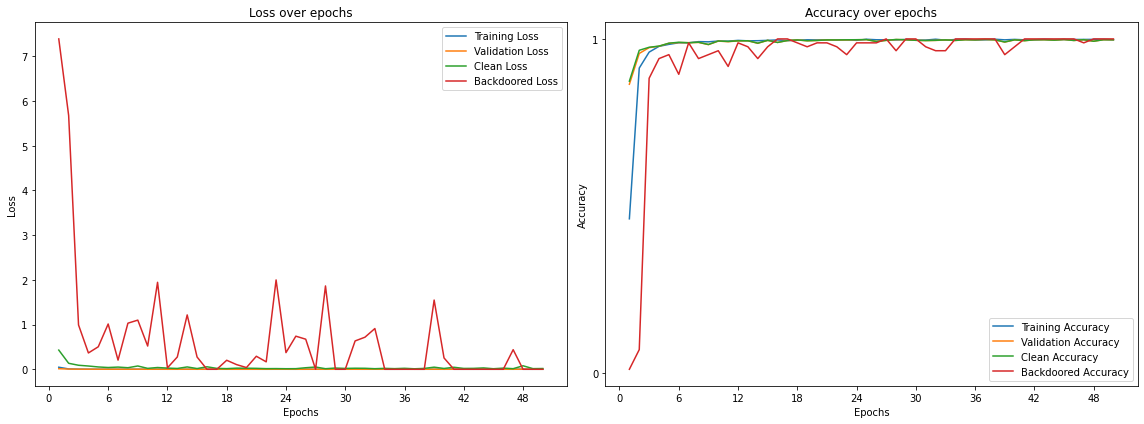

Processing: 100%|██████████| 50/50 [40:04<00:00, 48.08s/iteration]


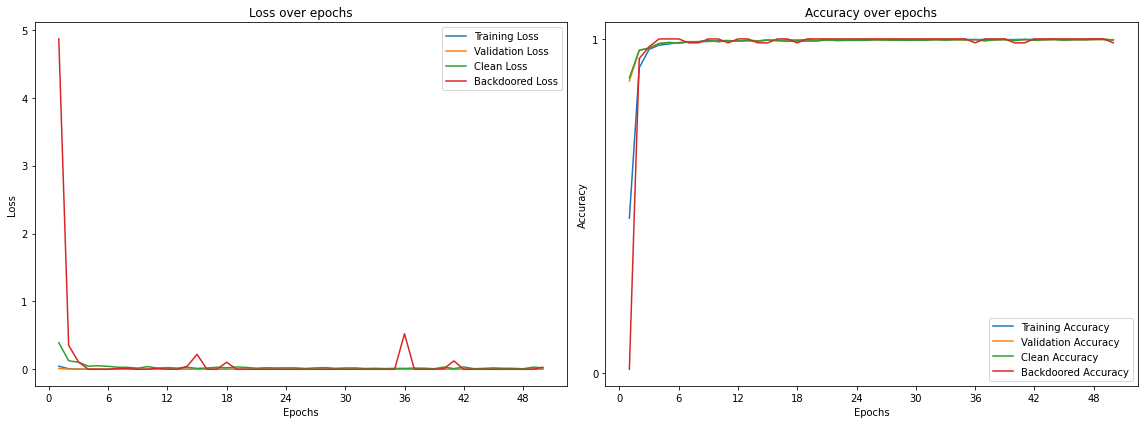

Processing: 100%|██████████| 50/50 [40:31<00:00, 48.62s/iteration]


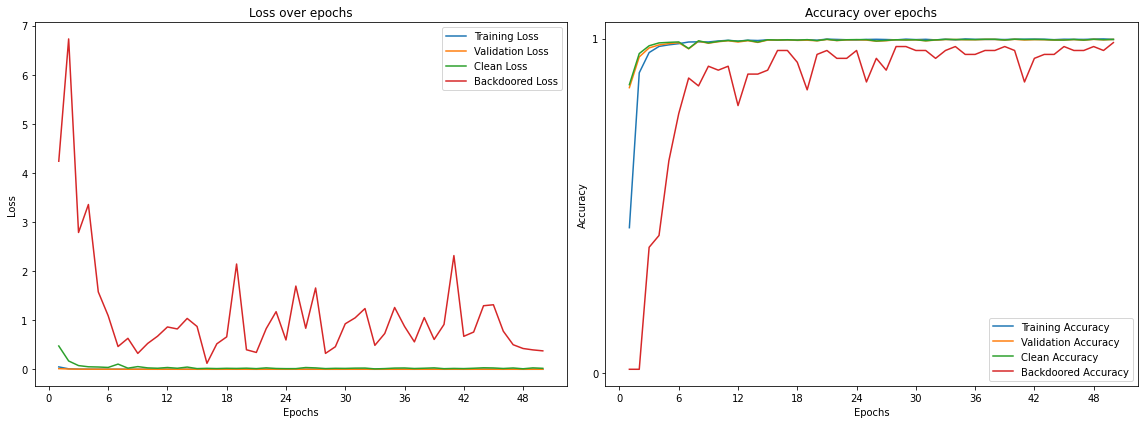

Processing: 100%|██████████| 50/50 [40:47<00:00, 48.95s/iteration]


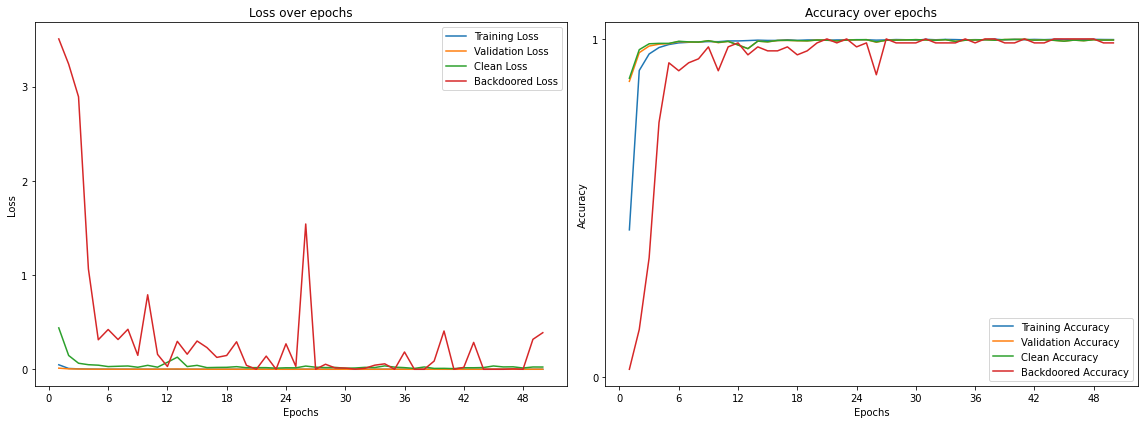

Processing: 100%|██████████| 50/50 [41:17<00:00, 49.54s/iteration]


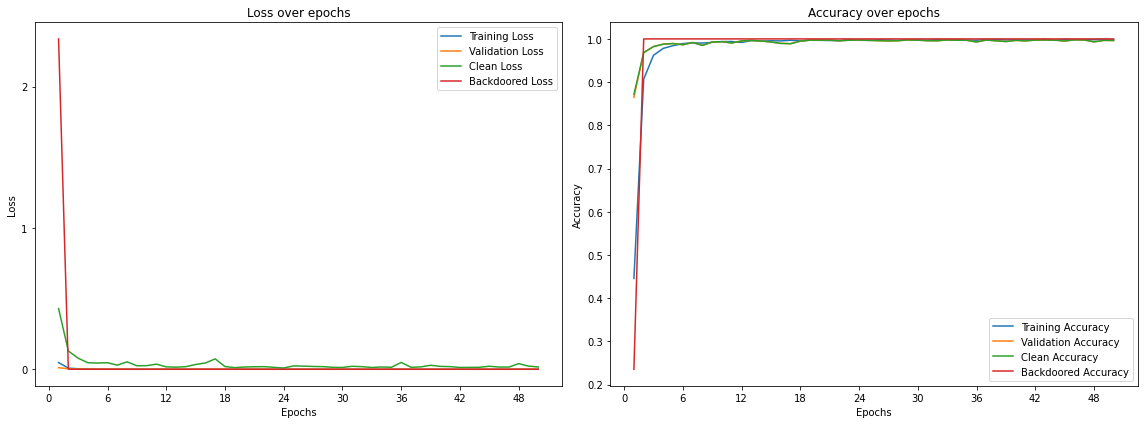

Processing: 100%|██████████| 50/50 [41:26<00:00, 49.72s/iteration]


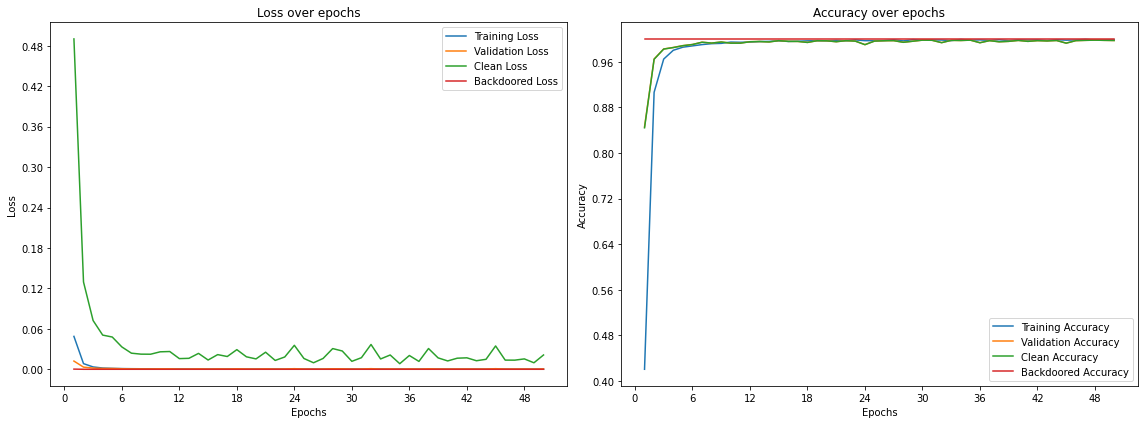

Processing: 100%|██████████| 50/50 [42:25<00:00, 50.90s/iteration]


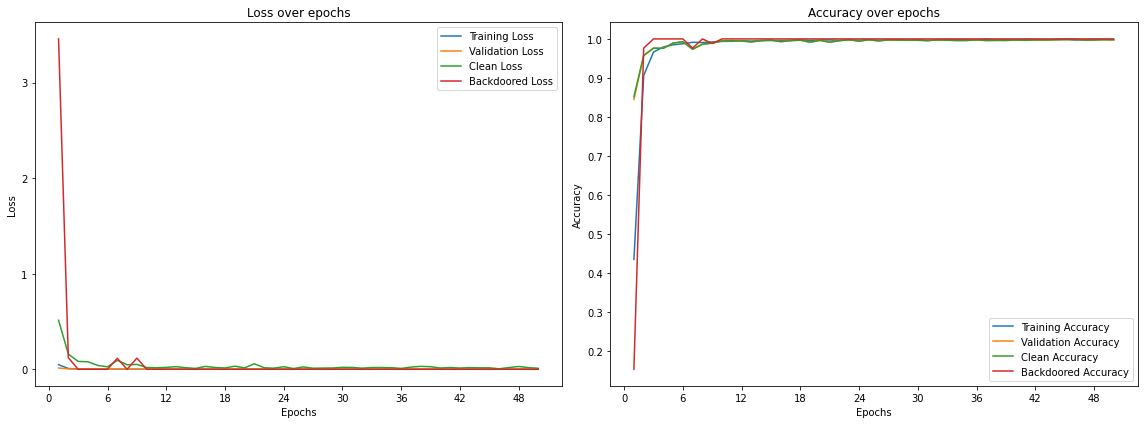

Processing: 100%|██████████| 50/50 [42:36<00:00, 51.13s/iteration]


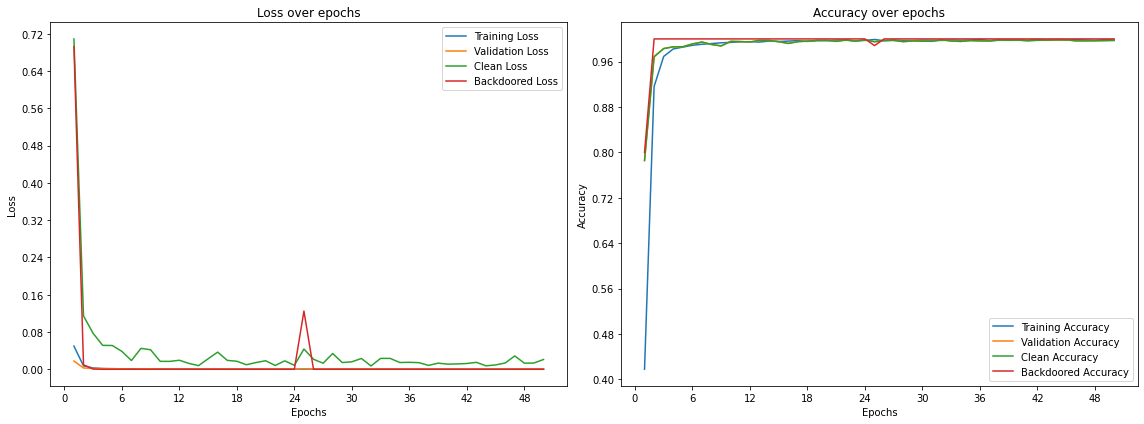

In [7]:
# With clean and backdoored validation
import numpy as np 
import pandas as pd 
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
import seaborn as sns
import matplotlib.pyplot as plt
import random
import seaborn as sns
from collections import Counter

from PIL import Image
from skimage import io

from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split, Dataset, ConcatDataset
import torch.optim as optim

import torchvision.datasets
import torchvision.transforms as T 
from torchvision.io import read_image
from torchvision.datasets import DatasetFolder
from torchvision.datasets.folder import default_loader
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Transforming the Data ToTensor and Normalize it 
transforms = T.Compose([T.ToTensor(),T.Resize((256,256)),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

class TSignsDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.data = []
        self.class_counts = Counter()  # Counter to store class counts
        
        # Iterate over each folder (class) in the directory
        for class_id in os.listdir(root_dir):
            class_dir = os.path.join(root_dir, class_id)
            
            # Make sure it's a directory
            if os.path.isdir(class_dir):
                for filename in os.listdir(class_dir):
                    if filename.endswith(".jpg") or filename.endswith(".png"):
                        self.data.append({
                            'path': os.path.join(class_dir, filename),
                            'class_id': int(class_id)
                        })
                        # Increment the count for the current class_id
                        self.class_counts[int(class_id)] += 1
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        image_path = self.data[index]['path']
        image = Image.open(image_path)
        y_class = torch.tensor(self.data[index]['class_id'])
        
        if self.transform:
            image = self.transform(image)

        return (image, y_class)
    
# Prepare clean dataset
dataset_path = '/home/cc7486/Desktop/Research/MLLsecurity/gtsrb-german-traffic-sign/Train'
clean_dataset_set = TSignsDataset(dataset_path,transform=transforms) 
L1 = len(clean_dataset_set)
Len1 = int(0.8*L1)
train_set, val_set = random_split(clean_dataset_set,[Len1,int(L1-Len1)])

def Train(model,criterion,optimizer,num_epochs,batch_size,dataloaders,out_path):
        best_model_weights = model.state_dict()
        best_acc = 0.0
        train_best_acc = 0.0
    
        for epoch in tqdm(range(num_epochs), desc="Processing", unit="iteration"):
            # print("epoch {}/{}".format(epoch+1,num_epochs))
            # print("*" * 10)

            for x in ["training","validation","clean","backdoor"]:
                if x == "training" :
                    model.train()
                else:
                    model.eval()

                running_loss = 0.0
                running_accuracy = 0

                for data in dataloaders[x]:
                    img , y = data
                    img , y = img.to(device) , y.to(device)

                    optimizer.zero_grad()
                    y_pred = model(img)
                    loss = criterion(y_pred,y)
                    _, preds = torch.max(y_pred, dim=1)

                    if x == 'training':
                        loss.backward()
                        optimizer.step()

                    running_loss += loss.item()
                    running_accuracy += torch.sum(preds == y.data)


                epoch_loss = running_loss / dataset_sizes[x]
                epoch_acc = running_accuracy / dataset_sizes[x]

                # print('{} Loss: {:.4f} || Accuracy: {:.4f}'.format(x, epoch_loss, epoch_acc))

                # Save metrics
                if x == 'training':
                    train_loss.append(epoch_loss)
                    train_acc.append(epoch_acc)
                elif x == "validation":
                    val_loss.append(epoch_loss)
                    val_acc.append(epoch_acc)
                elif x == "clean":
                    clean_loss.append(epoch_loss)
                    clean_acc.append(epoch_acc)
                else:
                    back_loss.append(epoch_loss)
                    back_acc.append(epoch_acc)

                # deep copy the model
                if x == 'validation' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                elif x == "training" and epoch_acc > best_acc:
                    train_best_acc = epoch_acc


        # load best model weights
        torch.save(model.state_dict(), out_path)
        print('Best training Accuracy: {:4f}'.format(train_best_acc))
        print('Best validation Accuracy: {:4f}'.format(best_acc))

for case in range(1, 9):
    datas_path = f'/home/cc7486/Desktop/Research/MLLsecurity/gtsrb-german-traffic-sign/backdoored-train/Fix-gen/Train_test_{case}/'
    bck_dataset_set = TSignsDataset(datas_path,transform=transforms)

    #splitting the data into training and validation
    L2 = len(bck_dataset_set)
    # print(f"Total length of Dataset Imported: ",L1, L2, L1+L2)
    Len2 = int(0.8*L2)
    bck_train_set, bck_val_set = random_split(bck_dataset_set,[Len2,int(L2-Len2)])

    # Combine Datasets
    train_set = ConcatDataset([train_set, bck_train_set])
    vali_set = ConcatDataset([val_set, bck_val_set])

    #Loading the data into DataLoader
    train_loader = DataLoader(dataset=train_set, batch_size=40, shuffle=True)
    valid_loader = DataLoader(dataset=vali_set, batch_size=40, shuffle=True)
    # valid_loader = DataLoader(dataset=vali_set, batch_size=40, shuffle=False)
    clean_val_loader = DataLoader(dataset=val_set, batch_size=1, shuffle=False)
    bck_val_loader = DataLoader(dataset=bck_val_set, batch_size=1, shuffle=False)

    dataloaders = {'training':train_loader,'validation':valid_loader, "clean": clean_val_loader, "backdoor": bck_val_loader}
    dataset_sizes = {'training':len(train_loader.dataset),'validation':len(valid_loader.dataset), "clean": len(clean_val_loader), "backdoor": len(bck_val_loader)}
    # print(dataset_sizes)

    # Store metrics
    train_loss, val_loss, clean_loss, back_loss = [], [], [], []
    train_acc, val_acc, clean_acc, back_acc = [], [], [], []


    from torchvision.models import alexnet
    model = alexnet(weights=None, num_classes=43).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(),lr = 0.0001)
    num_epochs = 50
    batch_size = 40
    out_path = f"50-epoch_models/alexnet_case_{case}.pt"

    #train the model
    Train(model,criterion,optimizer,num_epochs,batch_size,dataloaders,out_path)

    import numpy as np
    from matplotlib.ticker import MaxNLocator
    # Convert the lists to numpy arrays for indexing
    train_los = np.array([tl.cpu() if isinstance(tl, torch.Tensor) else tl for tl in train_loss])
    val_los = np.array([vl.cpu() if isinstance(vl, torch.Tensor) else vl for vl in val_loss])
    clean_los = np.array([tl.cpu() if isinstance(tl, torch.Tensor) else tl for tl in clean_loss])
    back_los = np.array([vl.cpu() if isinstance(vl, torch.Tensor) else vl for vl in back_loss])
    train_ac = np.array([ta.cpu() if isinstance(ta, torch.Tensor) else ta for ta in train_acc])
    val_ac = np.array([va.cpu() if isinstance(va, torch.Tensor) else va for va in val_acc])
    clean_ac = np.array([ta.cpu() if isinstance(ta, torch.Tensor) else ta for ta in clean_acc])
    back_ac = np.array([va.cpu() if isinstance(va, torch.Tensor) else va for va in back_acc])
    epochs = len(train_loss) 

    plt.figure(figsize=(16, 6))

    # Plotting Loss
    plt.subplot(1, 2, 1)
    sns.lineplot(x=range(1, 1+epochs), y=train_los, label='Training Loss')
    sns.lineplot(x=range(1, 1+epochs), y=val_los, label='Validation Loss')
    sns.lineplot(x=range(1, 1+epochs), y=clean_los, label='Clean Loss')
    sns.lineplot(x=range(1, 1+epochs), y=back_los, label='Backdoored Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss over epochs')
    plt.legend()
    plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.gca().yaxis.set_major_locator(MaxNLocator(integer=True))

    # Plotting Accuracy
    plt.subplot(1, 2, 2)
    sns.lineplot(x=range(1, 1+epochs), y=train_ac, label='Training Accuracy')
    sns.lineplot(x=range(1, 1+epochs), y=val_ac, label='Validation Accuracy')
    sns.lineplot(x=range(1, 1+epochs), y=clean_ac, label='Clean Accuracy')
    sns.lineplot(x=range(1, 1+epochs), y=back_ac, label='Backdoored Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Accuracy over epochs')
    plt.legend()
    plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.gca().yaxis.set_major_locator(MaxNLocator(integer=True))

    plt.tight_layout()
    plt.show()

Processing: 100%|██████████| 50/50 [38:58<00:00, 46.76s/iteration]


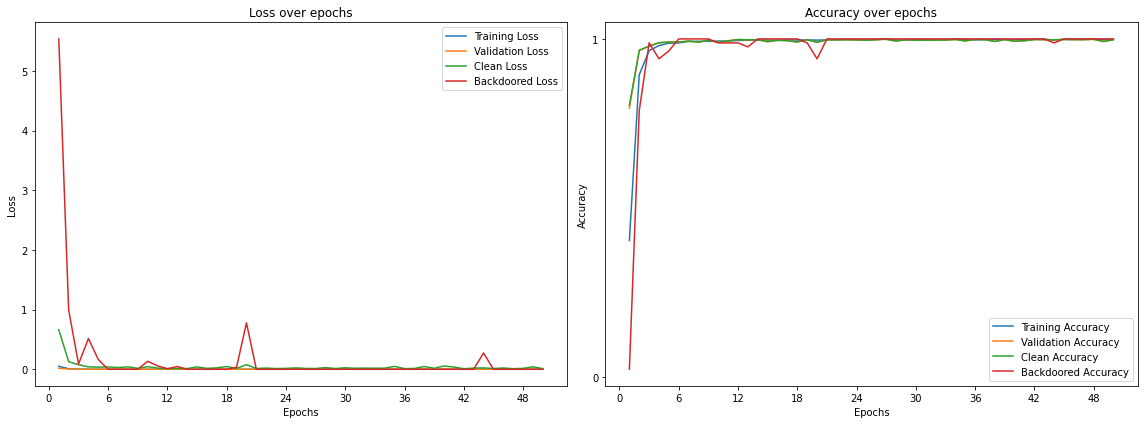

Processing: 100%|██████████| 50/50 [39:41<00:00, 47.62s/iteration]


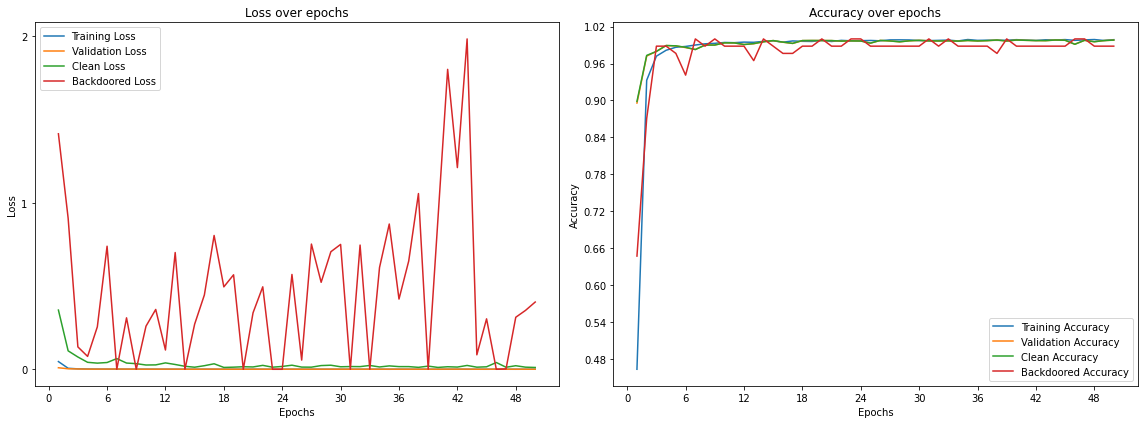

Processing: 100%|██████████| 50/50 [40:04<00:00, 48.08s/iteration]


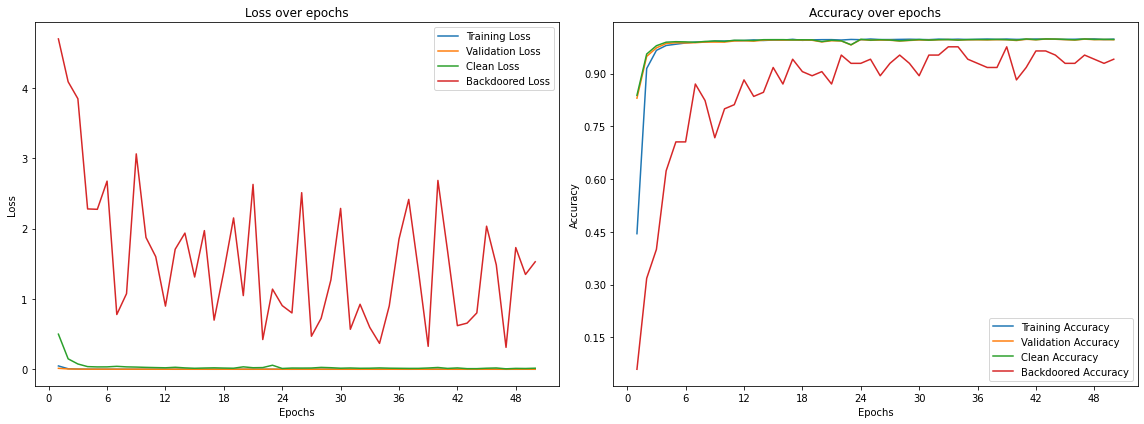

Processing: 100%|██████████| 50/50 [40:54<00:00, 49.09s/iteration]


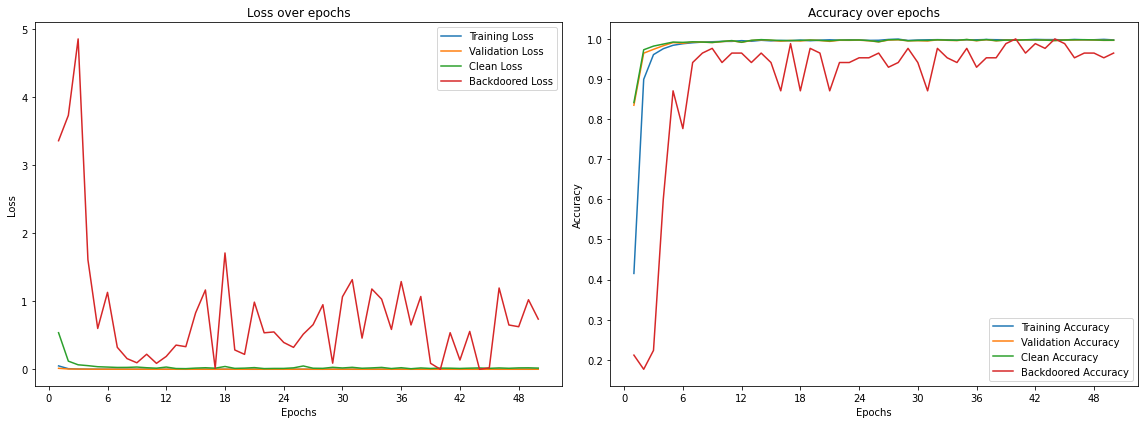

Processing: 100%|██████████| 50/50 [41:02<00:00, 49.25s/iteration]


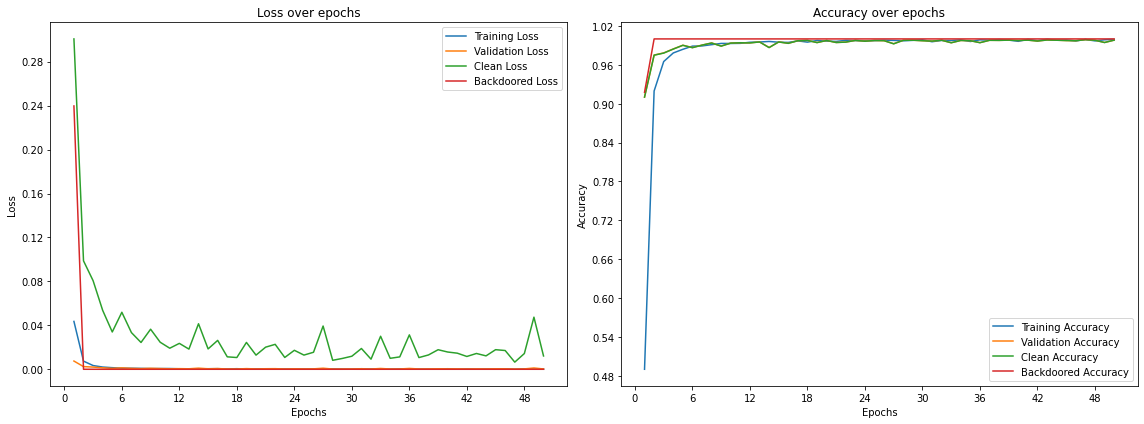

Processing: 100%|██████████| 50/50 [41:33<00:00, 49.88s/iteration]


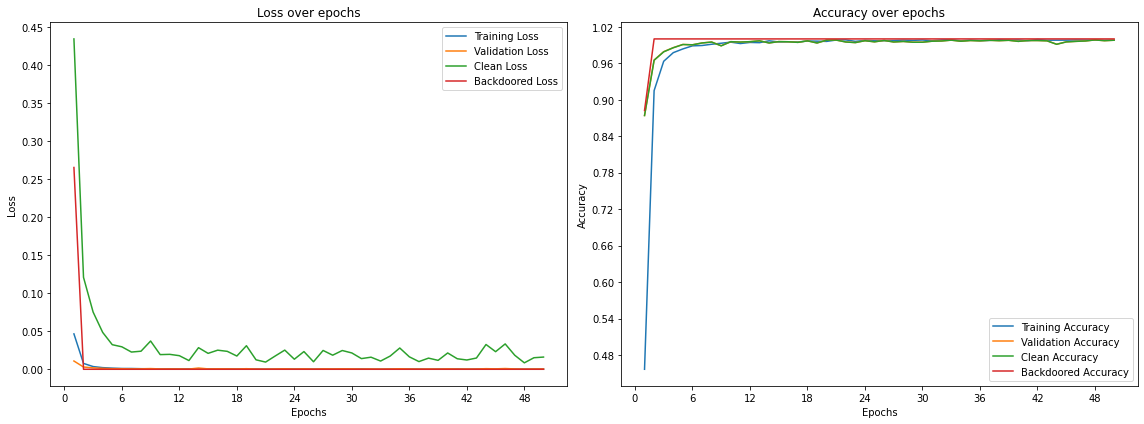

Processing: 100%|██████████| 50/50 [42:10<00:00, 50.62s/iteration]


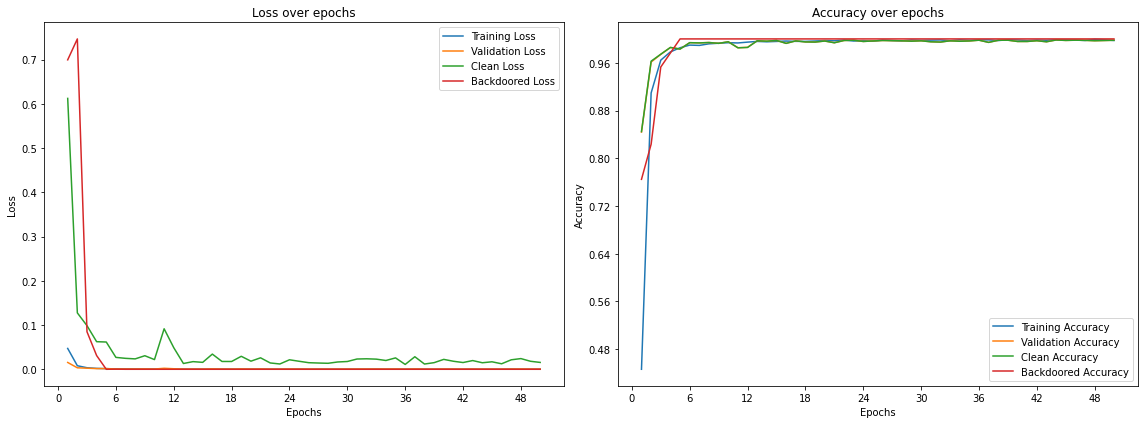

Processing: 100%|██████████| 50/50 [42:34<00:00, 51.09s/iteration]


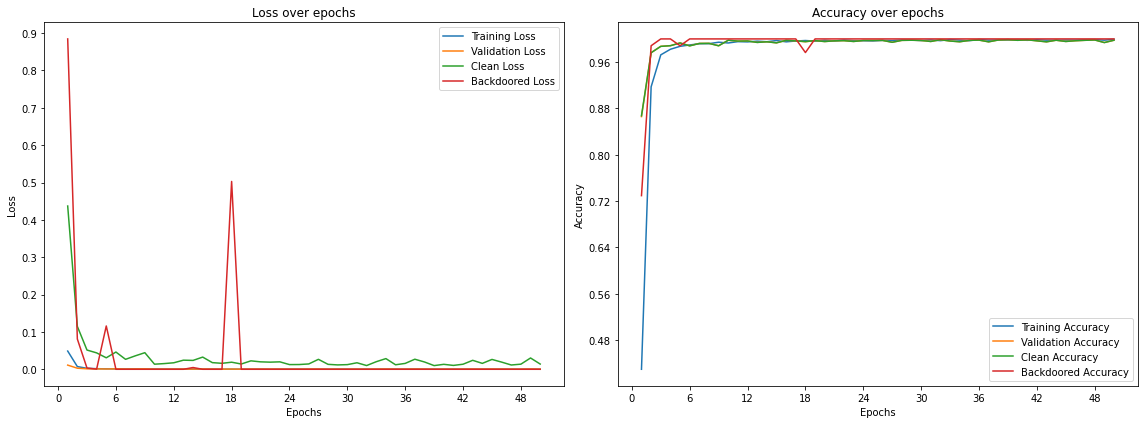

In [8]:
# With clean and backdoored validation
import numpy as np 
import pandas as pd 
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
import seaborn as sns
import matplotlib.pyplot as plt
import random
import seaborn as sns
from collections import Counter

from PIL import Image
from skimage import io

from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split, Dataset, ConcatDataset
import torch.optim as optim

import torchvision.datasets
import torchvision.transforms as T 
from torchvision.io import read_image
from torchvision.datasets import DatasetFolder
from torchvision.datasets.folder import default_loader
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Transforming the Data ToTensor and Normalize it 
transforms = T.Compose([T.ToTensor(),T.Resize((256,256)),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

class TSignsDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.data = []
        self.class_counts = Counter()  # Counter to store class counts
        
        # Iterate over each folder (class) in the directory
        for class_id in os.listdir(root_dir):
            class_dir = os.path.join(root_dir, class_id)
            
            # Make sure it's a directory
            if os.path.isdir(class_dir):
                for filename in os.listdir(class_dir):
                    if filename.endswith(".jpg") or filename.endswith(".png"):
                        self.data.append({
                            'path': os.path.join(class_dir, filename),
                            'class_id': int(class_id)
                        })
                        # Increment the count for the current class_id
                        self.class_counts[int(class_id)] += 1
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        image_path = self.data[index]['path']
        image = Image.open(image_path)
        y_class = torch.tensor(self.data[index]['class_id'])
        
        if self.transform:
            image = self.transform(image)

        return (image, y_class)
    
# Prepare clean dataset
dataset_path = '/home/cc7486/Desktop/Research/MLLsecurity/gtsrb-german-traffic-sign/Train'
clean_dataset_set = TSignsDataset(dataset_path,transform=transforms) 
L1 = len(clean_dataset_set)
Len1 = int(0.8*L1)
train_set, val_set = random_split(clean_dataset_set,[Len1,int(L1-Len1)])

def Train(model,criterion,optimizer,num_epochs,batch_size,dataloaders,out_path):
        best_model_weights = model.state_dict()
        best_acc = 0.0
    
        for epoch in tqdm(range(num_epochs), desc="Processing", unit="iteration"):
            # print("epoch {}/{}".format(epoch+1,num_epochs))
            # print("*" * 10)

            for x in ["training","validation","clean","backdoor"]:
                if x == "training" :
                    model.train()
                else:
                    model.eval()

                running_loss = 0.0
                running_accuracy = 0

                for data in dataloaders[x]:
                    img , y = data
                    img , y = img.to(device) , y.to(device)

                    optimizer.zero_grad()
                    y_pred = model(img)
                    loss = criterion(y_pred,y)
                    _, preds = torch.max(y_pred, dim=1)

                    if x == 'training':
                        loss.backward()
                        optimizer.step()

                    running_loss += loss.item()
                    running_accuracy += torch.sum(preds == y.data)


                epoch_loss = running_loss / dataset_sizes[x]
                epoch_acc = running_accuracy / dataset_sizes[x]

                # print('{} Loss: {:.4f} || Accuracy: {:.4f}'.format(x, epoch_loss, epoch_acc))

                # Save metrics
                if x == 'training':
                    train_loss.append(epoch_loss)
                    train_acc.append(epoch_acc)
                elif x == "validation":
                    val_loss.append(epoch_loss)
                    val_acc.append(epoch_acc)
                elif x == "clean":
                    clean_loss.append(epoch_loss)
                    clean_acc.append(epoch_acc)
                else:
                    back_loss.append(epoch_loss)
                    back_acc.append(epoch_acc)

                # deep copy the model
                if x == 'validation' and epoch_acc > best_acc:
                    best_acc = epoch_acc


        # load best model weights
        torch.save(model.state_dict(), out_path)
        #print('Best validation Accuracy: {:4f}'.format(best_acc))

for case in range(9, 17):
    datas_path = f'/home/cc7486/Desktop/Research/MLLsecurity/gtsrb-german-traffic-sign/backdoored-train/Fix-gen/Train_test_{case}/'
    bck_dataset_set = TSignsDataset(datas_path,transform=transforms)

    #splitting the data into training and validation
    L2 = len(bck_dataset_set)
    # print(f"Total length of Dataset Imported: ",L1, L2, L1+L2)
    Len2 = int(0.8*L2)
    bck_train_set, bck_val_set = random_split(bck_dataset_set,[Len2,int(L2-Len2)])

    # Combine Datasets
    train_set = ConcatDataset([train_set, bck_train_set])
    vali_set = ConcatDataset([val_set, bck_val_set])

    #Loading the data into DataLoader
    train_loader = DataLoader(dataset=train_set, batch_size=40, shuffle=True)
    valid_loader = DataLoader(dataset=vali_set, batch_size=40, shuffle=True)
    # valid_loader = DataLoader(dataset=vali_set, batch_size=40, shuffle=False)
    clean_val_loader = DataLoader(dataset=val_set, batch_size=1, shuffle=False)
    bck_val_loader = DataLoader(dataset=bck_val_set, batch_size=1, shuffle=False)

    dataloaders = {'training':train_loader,'validation':valid_loader, "clean": clean_val_loader, "backdoor": bck_val_loader}
    dataset_sizes = {'training':len(train_loader.dataset),'validation':len(valid_loader.dataset), "clean": len(clean_val_loader), "backdoor": len(bck_val_loader)}
    # print(dataset_sizes)

    # Store metrics
    train_loss, val_loss, clean_loss, back_loss = [], [], [], []
    train_acc, val_acc, clean_acc, back_acc = [], [], [], []


    from torchvision.models import alexnet
    model = alexnet(weights=None, num_classes=43).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(),lr = 0.0001)
    num_epochs = 50
    batch_size = 40
    out_path = f"50-epoch_models/alexnet_case_{case}.pt"

    #train the model
    Train(model,criterion,optimizer,num_epochs,batch_size,dataloaders,out_path)

    import numpy as np
    from matplotlib.ticker import MaxNLocator
    # Convert the lists to numpy arrays for indexing
    train_los = np.array([tl.cpu() if isinstance(tl, torch.Tensor) else tl for tl in train_loss])
    val_los = np.array([vl.cpu() if isinstance(vl, torch.Tensor) else vl for vl in val_loss])
    clean_los = np.array([tl.cpu() if isinstance(tl, torch.Tensor) else tl for tl in clean_loss])
    back_los = np.array([vl.cpu() if isinstance(vl, torch.Tensor) else vl for vl in back_loss])
    train_ac = np.array([ta.cpu() if isinstance(ta, torch.Tensor) else ta for ta in train_acc])
    val_ac = np.array([va.cpu() if isinstance(va, torch.Tensor) else va for va in val_acc])
    clean_ac = np.array([ta.cpu() if isinstance(ta, torch.Tensor) else ta for ta in clean_acc])
    back_ac = np.array([va.cpu() if isinstance(va, torch.Tensor) else va for va in back_acc])
    epochs = len(train_loss) 

    plt.figure(figsize=(16, 6))

    # Plotting Loss
    plt.subplot(1, 2, 1)
    sns.lineplot(x=range(1, 1+epochs), y=train_los, label='Training Loss')
    sns.lineplot(x=range(1, 1+epochs), y=val_los, label='Validation Loss')
    sns.lineplot(x=range(1, 1+epochs), y=clean_los, label='Clean Loss')
    sns.lineplot(x=range(1, 1+epochs), y=back_los, label='Backdoored Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss over epochs')
    plt.legend()
    plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.gca().yaxis.set_major_locator(MaxNLocator(integer=True))

    # Plotting Accuracy
    plt.subplot(1, 2, 2)
    sns.lineplot(x=range(1, 1+epochs), y=train_ac, label='Training Accuracy')
    sns.lineplot(x=range(1, 1+epochs), y=val_ac, label='Validation Accuracy')
    sns.lineplot(x=range(1, 1+epochs), y=clean_ac, label='Clean Accuracy')
    sns.lineplot(x=range(1, 1+epochs), y=back_ac, label='Backdoored Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Accuracy over epochs')
    plt.legend()
    plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.gca().yaxis.set_major_locator(MaxNLocator(integer=True))

    plt.tight_layout()
    plt.show()

Processing: 100%|██████████| 50/50 [39:24<00:00, 47.29s/iteration]


Best validation Accuracy: 0.998001


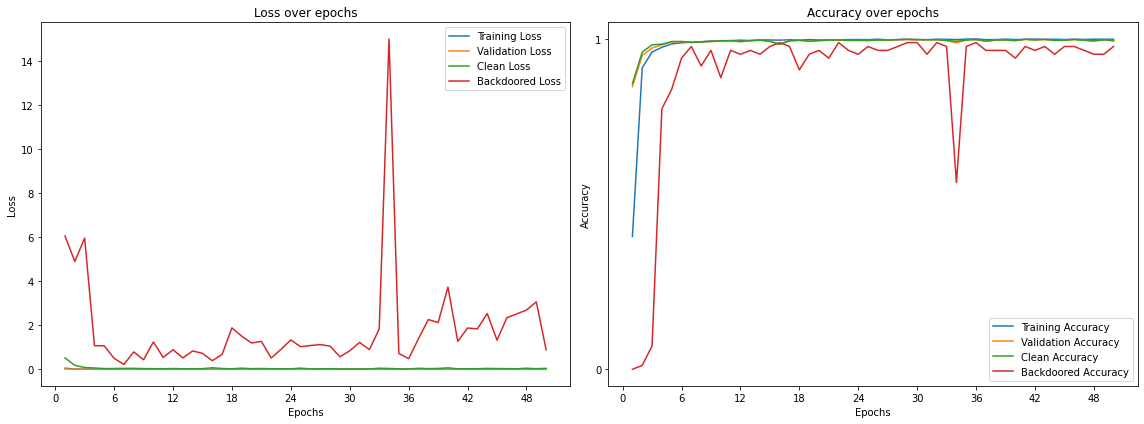

Processing: 100%|██████████| 50/50 [40:01<00:00, 48.02s/iteration]


Best validation Accuracy: 0.998001


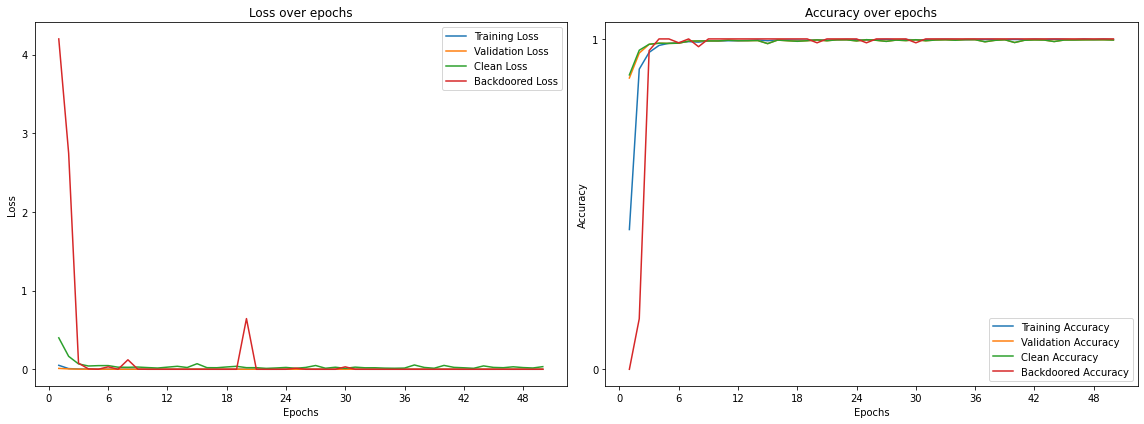

Processing: 100%|██████████| 50/50 [40:24<00:00, 48.50s/iteration]


Best validation Accuracy: 0.996751


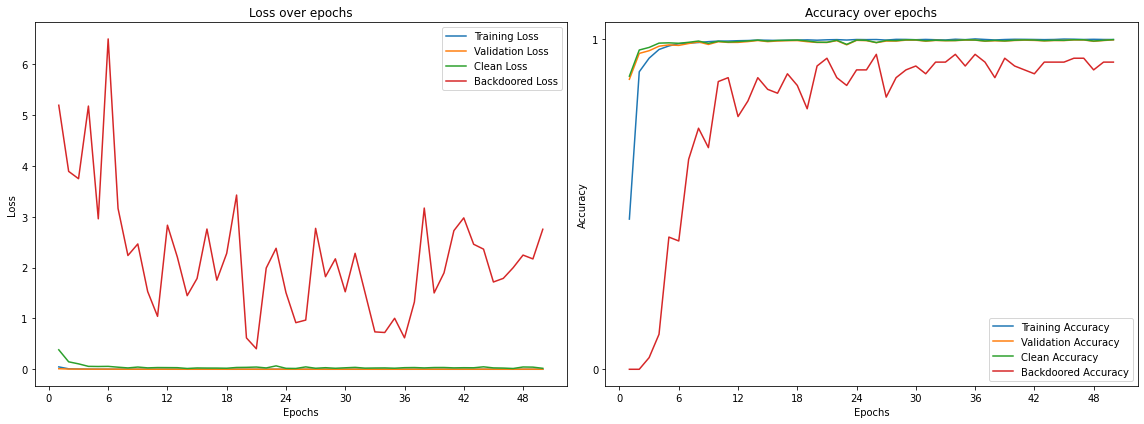

Processing: 100%|██████████| 50/50 [40:54<00:00, 49.09s/iteration]


Best validation Accuracy: 0.996876


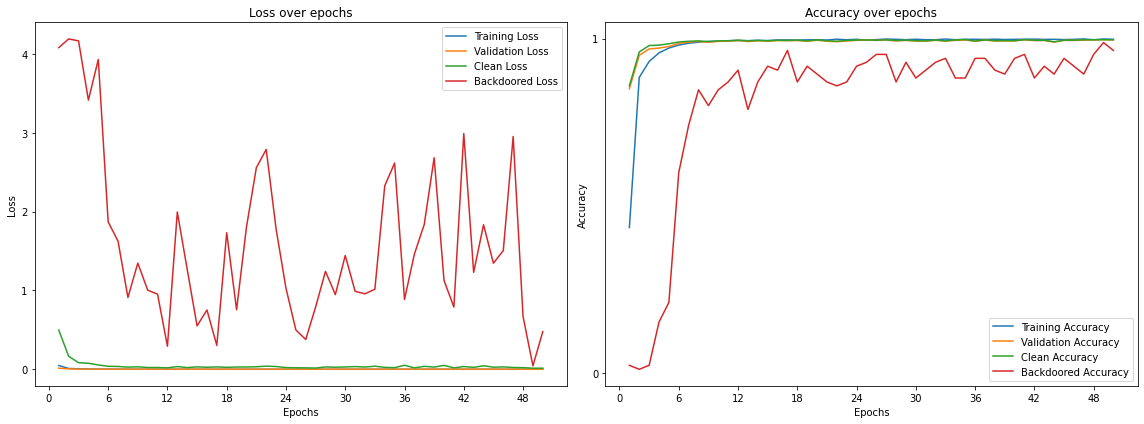

Processing: 100%|██████████| 50/50 [41:28<00:00, 49.76s/iteration]


Best validation Accuracy: 0.997501


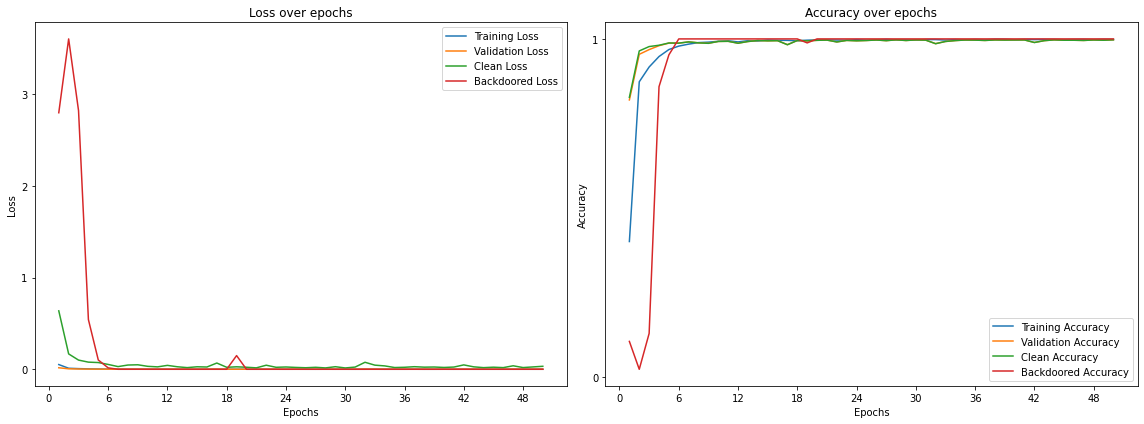

Processing: 100%|██████████| 50/50 [42:00<00:00, 50.41s/iteration]


Best validation Accuracy: 0.997751


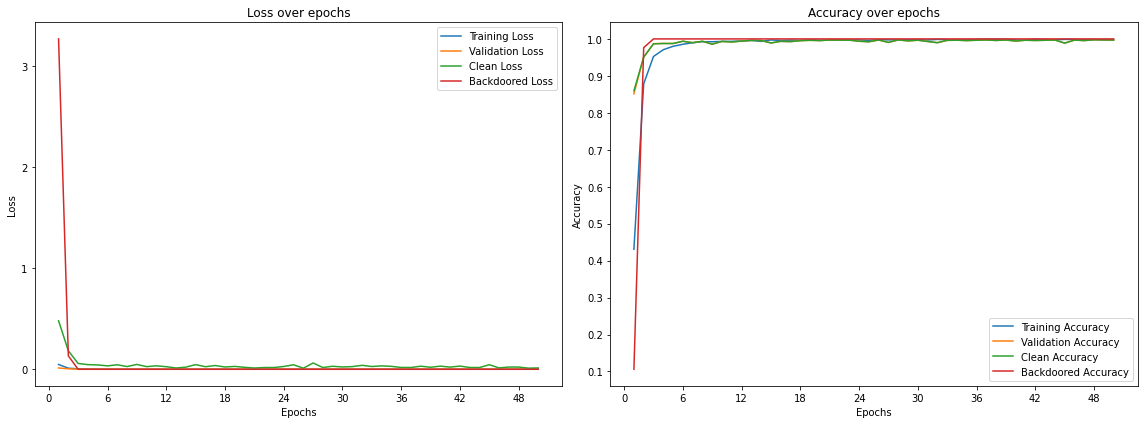

Processing: 100%|██████████| 50/50 [42:31<00:00, 51.04s/iteration]


Best validation Accuracy: 0.998001


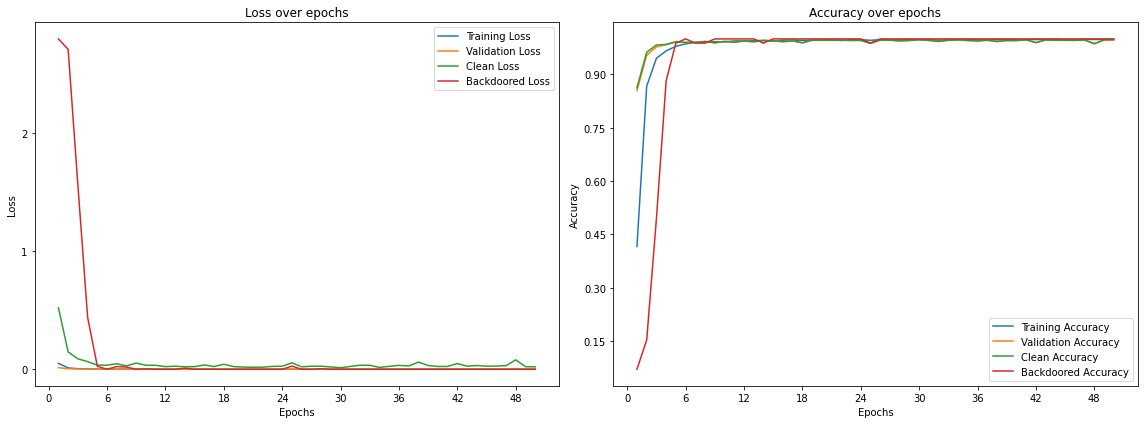

Processing: 100%|██████████| 50/50 [42:53<00:00, 51.46s/iteration]


Best validation Accuracy: 0.997251


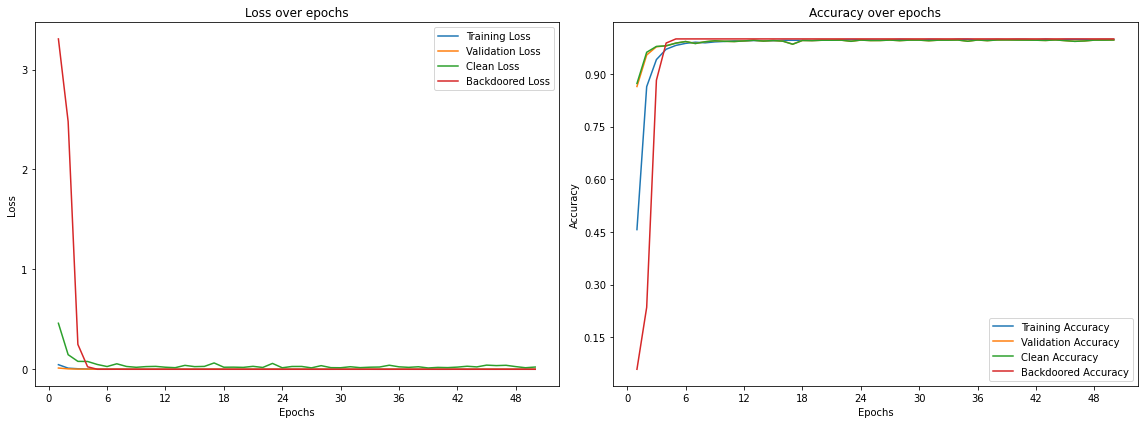

In [1]:
# With clean and backdoored validation
import numpy as np 
import pandas as pd 
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
import seaborn as sns
import matplotlib.pyplot as plt
import random
import seaborn as sns
from collections import Counter

from PIL import Image
from skimage import io

from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split, Dataset, ConcatDataset
import torch.optim as optim

import torchvision.datasets
import torchvision.transforms as T 
from torchvision.io import read_image
from torchvision.datasets import DatasetFolder
from torchvision.datasets.folder import default_loader
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Transforming the Data ToTensor and Normalize it 
transforms = T.Compose([T.ToTensor(),T.Resize((256,256)),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

class TSignsDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.data = []
        self.class_counts = Counter()  # Counter to store class counts
        
        # Iterate over each folder (class) in the directory
        for class_id in os.listdir(root_dir):
            class_dir = os.path.join(root_dir, class_id)
            
            # Make sure it's a directory
            if os.path.isdir(class_dir):
                for filename in os.listdir(class_dir):
                    if filename.endswith(".jpg") or filename.endswith(".png"):
                        self.data.append({
                            'path': os.path.join(class_dir, filename),
                            'class_id': int(class_id)
                        })
                        # Increment the count for the current class_id
                        self.class_counts[int(class_id)] += 1
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        image_path = self.data[index]['path']
        image = Image.open(image_path)
        y_class = torch.tensor(self.data[index]['class_id'])
        
        if self.transform:
            image = self.transform(image)

        return (image, y_class)
    
# Prepare clean dataset
dataset_path = '/home/cc7486/Desktop/Research/MLLsecurity/gtsrb-german-traffic-sign/Train'
clean_dataset_set = TSignsDataset(dataset_path,transform=transforms) 
L1 = len(clean_dataset_set)
Len1 = int(0.8*L1)
train_set, val_set = random_split(clean_dataset_set,[Len1,int(L1-Len1)])

def Train(model,criterion,optimizer,num_epochs,batch_size,dataloaders,out_path):
        best_model_weights = model.state_dict()
        best_acc = 0.0
    
        for epoch in tqdm(range(num_epochs), desc="Processing", unit="iteration"):
            # print("epoch {}/{}".format(epoch+1,num_epochs))
            # print("*" * 10)

            for x in ["training","validation","clean","backdoor"]:
                if x == "training" :
                    model.train()
                else:
                    model.eval()

                running_loss = 0.0
                running_accuracy = 0

                for data in dataloaders[x]:
                    img , y = data
                    img , y = img.to(device) , y.to(device)

                    optimizer.zero_grad()
                    y_pred = model(img)
                    loss = criterion(y_pred,y)
                    _, preds = torch.max(y_pred, dim=1)

                    if x == 'training':
                        loss.backward()
                        optimizer.step()

                    running_loss += loss.item()
                    running_accuracy += torch.sum(preds == y.data)


                epoch_loss = running_loss / dataset_sizes[x]
                epoch_acc = running_accuracy / dataset_sizes[x]

                # print('{} Loss: {:.4f} || Accuracy: {:.4f}'.format(x, epoch_loss, epoch_acc))

                # Save metrics
                if x == 'training':
                    train_loss.append(epoch_loss)
                    train_acc.append(epoch_acc)
                elif x == "validation":
                    val_loss.append(epoch_loss)
                    val_acc.append(epoch_acc)
                elif x == "clean":
                    clean_loss.append(epoch_loss)
                    clean_acc.append(epoch_acc)
                else:
                    back_loss.append(epoch_loss)
                    back_acc.append(epoch_acc)

                # deep copy the model
                if x == 'validation' and epoch_acc > best_acc:
                    best_acc = epoch_acc


        # load best model weights
        torch.save(model.state_dict(), out_path)
        print('Best validation Accuracy: {:4f}'.format(best_acc))

for case in range(17, 25):
    datas_path = f'/home/cc7486/Desktop/Research/MLLsecurity/gtsrb-german-traffic-sign/backdoored-train/Fix-gen/Train_test_{case}/'
    bck_dataset_set = TSignsDataset(datas_path,transform=transforms)

    #splitting the data into training and validation
    L2 = len(bck_dataset_set)
    # print(f"Total length of Dataset Imported: ",L1, L2, L1+L2)
    Len2 = int(0.8*L2)
    bck_train_set, bck_val_set = random_split(bck_dataset_set,[Len2,int(L2-Len2)])

    # Combine Datasets
    train_set = ConcatDataset([train_set, bck_train_set])
    vali_set = ConcatDataset([val_set, bck_val_set])

    #Loading the data into DataLoader
    train_loader = DataLoader(dataset=train_set, batch_size=40, shuffle=True)
    valid_loader = DataLoader(dataset=vali_set, batch_size=40, shuffle=True)
    # valid_loader = DataLoader(dataset=vali_set, batch_size=40, shuffle=False)
    clean_val_loader = DataLoader(dataset=val_set, batch_size=1, shuffle=False)
    bck_val_loader = DataLoader(dataset=bck_val_set, batch_size=1, shuffle=False)

    dataloaders = {'training':train_loader,'validation':valid_loader, "clean": clean_val_loader, "backdoor": bck_val_loader}
    dataset_sizes = {'training':len(train_loader.dataset),'validation':len(valid_loader.dataset), "clean": len(clean_val_loader), "backdoor": len(bck_val_loader)}
    # print(dataset_sizes)

    # Store metrics
    train_loss, val_loss, clean_loss, back_loss = [], [], [], []
    train_acc, val_acc, clean_acc, back_acc = [], [], [], []


    from torchvision.models import alexnet
    model = alexnet(weights=None, num_classes=43).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(),lr = 0.0001)
    num_epochs = 50
    batch_size = 40
    out_path = f"50-epoch_models/alexnet_case_{case}.pt"

    #train the model
    Train(model,criterion,optimizer,num_epochs,batch_size,dataloaders,out_path)

    import numpy as np
    from matplotlib.ticker import MaxNLocator
    # Convert the lists to numpy arrays for indexing
    train_los = np.array([tl.cpu() if isinstance(tl, torch.Tensor) else tl for tl in train_loss])
    val_los = np.array([vl.cpu() if isinstance(vl, torch.Tensor) else vl for vl in val_loss])
    clean_los = np.array([tl.cpu() if isinstance(tl, torch.Tensor) else tl for tl in clean_loss])
    back_los = np.array([vl.cpu() if isinstance(vl, torch.Tensor) else vl for vl in back_loss])
    train_ac = np.array([ta.cpu() if isinstance(ta, torch.Tensor) else ta for ta in train_acc])
    val_ac = np.array([va.cpu() if isinstance(va, torch.Tensor) else va for va in val_acc])
    clean_ac = np.array([ta.cpu() if isinstance(ta, torch.Tensor) else ta for ta in clean_acc])
    back_ac = np.array([va.cpu() if isinstance(va, torch.Tensor) else va for va in back_acc])
    epochs = len(train_loss) 

    plt.figure(figsize=(16, 6))

    # Plotting Loss
    plt.subplot(1, 2, 1)
    sns.lineplot(x=range(1, 1+epochs), y=train_los, label='Training Loss')
    sns.lineplot(x=range(1, 1+epochs), y=val_los, label='Validation Loss')
    sns.lineplot(x=range(1, 1+epochs), y=clean_los, label='Clean Loss')
    sns.lineplot(x=range(1, 1+epochs), y=back_los, label='Backdoored Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss over epochs')
    plt.legend()
    plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.gca().yaxis.set_major_locator(MaxNLocator(integer=True))

    # Plotting Accuracy
    plt.subplot(1, 2, 2)
    sns.lineplot(x=range(1, 1+epochs), y=train_ac, label='Training Accuracy')
    sns.lineplot(x=range(1, 1+epochs), y=val_ac, label='Validation Accuracy')
    sns.lineplot(x=range(1, 1+epochs), y=clean_ac, label='Clean Accuracy')
    sns.lineplot(x=range(1, 1+epochs), y=back_ac, label='Backdoored Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Accuracy over epochs')
    plt.legend()
    plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.gca().yaxis.set_major_locator(MaxNLocator(integer=True))

    plt.tight_layout()
    plt.show()

Processing: 100%|██████████| 50/50 [40:08<00:00, 48.16s/iteration]


Best training Accuracy: 0.998482
Best validation Accuracy: 0.997769


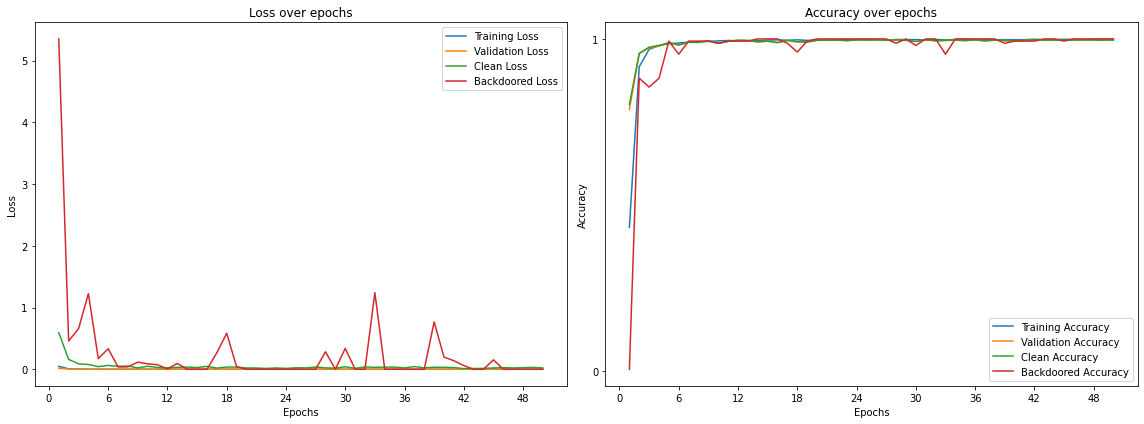

Processing: 100%|██████████| 50/50 [1:06:06<00:00, 79.34s/iteration] 


Best training Accuracy: 0.999027
Best validation Accuracy: 0.997893


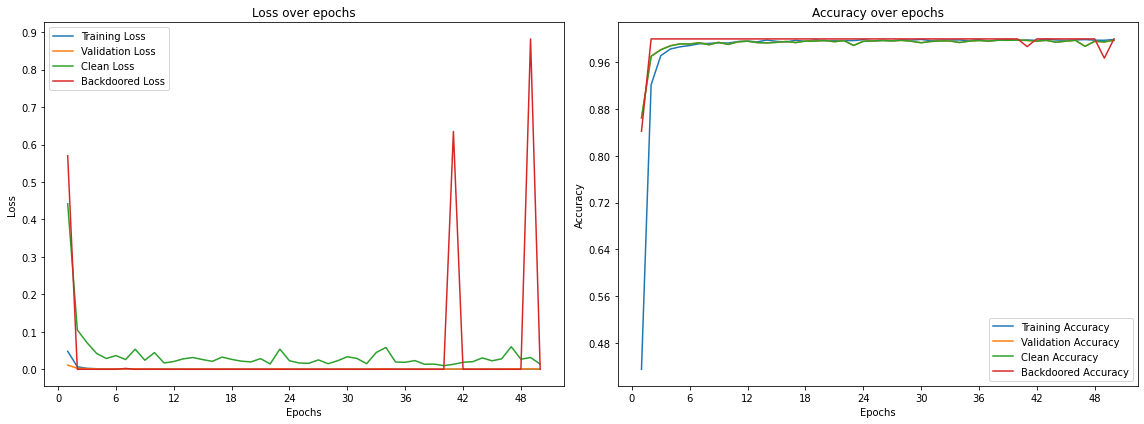

Processing: 100%|██████████| 50/50 [41:28<00:00, 49.78s/iteration]


Best training Accuracy: 0.999701
Best validation Accuracy: 0.998637


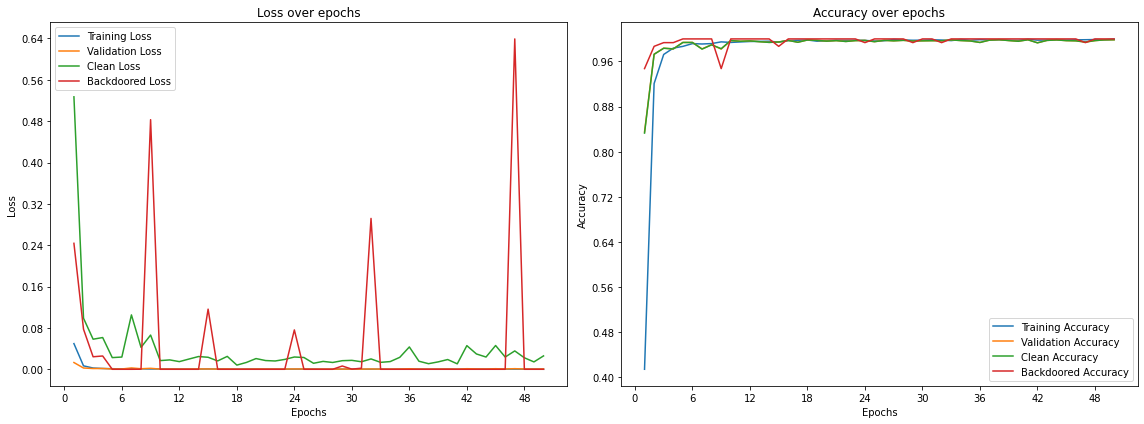

Processing: 100%|██████████| 50/50 [42:16<00:00, 50.74s/iteration]


Best training Accuracy: 0.999178
Best validation Accuracy: 0.998265


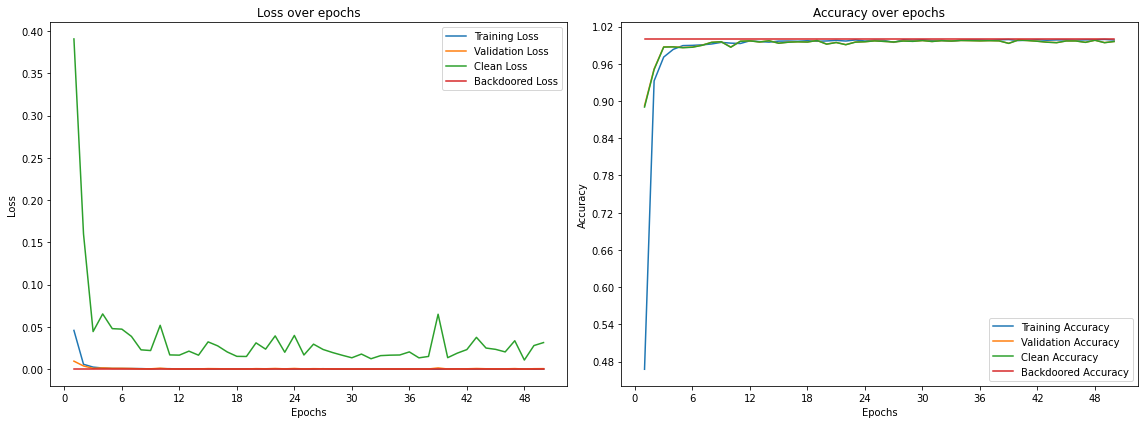

In [1]:
# With clean and backdoored validation
import numpy as np 
import pandas as pd 
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
import seaborn as sns
import matplotlib.pyplot as plt
import random
import seaborn as sns
from collections import Counter

from PIL import Image
from skimage import io

from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split, Dataset, ConcatDataset
import torch.optim as optim

import torchvision.datasets
import torchvision.transforms as T 
from torchvision.io import read_image
from torchvision.datasets import DatasetFolder
from torchvision.datasets.folder import default_loader
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Transforming the Data ToTensor and Normalize it 
transforms = T.Compose([T.ToTensor(),T.Resize((256,256)),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

class TSignsDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.data = []
        self.class_counts = Counter()  # Counter to store class counts
        
        # Iterate over each folder (class) in the directory
        for class_id in os.listdir(root_dir):
            class_dir = os.path.join(root_dir, class_id)
            
            # Make sure it's a directory
            if os.path.isdir(class_dir):
                for filename in os.listdir(class_dir):
                    if filename.endswith(".jpg") or filename.endswith(".png"):
                        self.data.append({
                            'path': os.path.join(class_dir, filename),
                            'class_id': int(class_id)
                        })
                        # Increment the count for the current class_id
                        self.class_counts[int(class_id)] += 1
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        image_path = self.data[index]['path']
        image = Image.open(image_path)
        y_class = torch.tensor(self.data[index]['class_id'])
        
        if self.transform:
            image = self.transform(image)

        return (image, y_class)
    
# Prepare clean dataset
dataset_path = '/home/cc7486/Desktop/Research/MLLsecurity/gtsrb-german-traffic-sign/Train'
clean_dataset_set = TSignsDataset(dataset_path,transform=transforms) 
L1 = len(clean_dataset_set)
Len1 = int(0.8*L1)
train_set, val_set = random_split(clean_dataset_set,[Len1,int(L1-Len1)])

def Train(model,criterion,optimizer,num_epochs,batch_size,dataloaders,out_path):
        best_model_weights = model.state_dict()
        best_acc = 0.0
        train_best_acc = 0.0
    
        for epoch in tqdm(range(num_epochs), desc="Processing", unit="iteration"):
            # print("epoch {}/{}".format(epoch+1,num_epochs))
            # print("*" * 10)

            for x in ["training","validation","clean","backdoor"]:
                if x == "training" :
                    model.train()
                else:
                    model.eval()

                running_loss = 0.0
                running_accuracy = 0

                for data in dataloaders[x]:
                    img , y = data
                    img , y = img.to(device) , y.to(device)

                    optimizer.zero_grad()
                    y_pred = model(img)
                    loss = criterion(y_pred,y)
                    _, preds = torch.max(y_pred, dim=1)

                    if x == 'training':
                        loss.backward()
                        optimizer.step()

                    running_loss += loss.item()
                    running_accuracy += torch.sum(preds == y.data)


                epoch_loss = running_loss / dataset_sizes[x]
                epoch_acc = running_accuracy / dataset_sizes[x]

                # print('{} Loss: {:.4f} || Accuracy: {:.4f}'.format(x, epoch_loss, epoch_acc))

                # Save metrics
                if x == 'training':
                    train_loss.append(epoch_loss)
                    train_acc.append(epoch_acc)
                elif x == "validation":
                    val_loss.append(epoch_loss)
                    val_acc.append(epoch_acc)
                elif x == "clean":
                    clean_loss.append(epoch_loss)
                    clean_acc.append(epoch_acc)
                else:
                    back_loss.append(epoch_loss)
                    back_acc.append(epoch_acc)

                # deep copy the model
                if x == 'validation' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                elif x == "training" and epoch_acc > best_acc:
                    train_best_acc = epoch_acc


        # load best model weights
        torch.save(model.state_dict(), out_path)
        print('Best training Accuracy: {:4f}'.format(train_best_acc))
        print('Best validation Accuracy: {:4f}'.format(best_acc))

for case in range(1, 7):
    if case in [3,4]:
        continue
    datas_path = f'/home/cc7486/Desktop/Research/MLLsecurity/gtsrb-german-traffic-sign/backdoored-train/780/Train_test_{case}/'
    bck_dataset_set = TSignsDataset(datas_path,transform=transforms)

    #splitting the data into training and validation
    L2 = len(bck_dataset_set)
    # print(f"Total length of Dataset Imported: ",L1, L2, L1+L2)
    Len2 = int(0.8*L2)
    bck_train_set, bck_val_set = random_split(bck_dataset_set,[Len2,int(L2-Len2)])

    # Combine Datasets
    train_set = ConcatDataset([train_set, bck_train_set])
    vali_set = ConcatDataset([val_set, bck_val_set])

    #Loading the data into DataLoader
    train_loader = DataLoader(dataset=train_set, batch_size=40, shuffle=True)
    valid_loader = DataLoader(dataset=vali_set, batch_size=40, shuffle=True)
    # valid_loader = DataLoader(dataset=vali_set, batch_size=40, shuffle=False)
    clean_val_loader = DataLoader(dataset=val_set, batch_size=1, shuffle=False)
    bck_val_loader = DataLoader(dataset=bck_val_set, batch_size=1, shuffle=False)

    dataloaders = {'training':train_loader,'validation':valid_loader, "clean": clean_val_loader, "backdoor": bck_val_loader}
    dataset_sizes = {'training':len(train_loader.dataset),'validation':len(valid_loader.dataset), "clean": len(clean_val_loader), "backdoor": len(bck_val_loader)}
    # print(dataset_sizes)

    # Store metrics
    train_loss, val_loss, clean_loss, back_loss = [], [], [], []
    train_acc, val_acc, clean_acc, back_acc = [], [], [], []


    from torchvision.models import alexnet
    model = alexnet(weights=None, num_classes=43).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr = 0.0001)
    num_epochs = 50
    batch_size = 40
    out_path = f"models/780/alexnet_case_{case}.pt"

    #train the model
    Train(model,criterion,optimizer,num_epochs,batch_size,dataloaders,out_path)

    import numpy as np
    from matplotlib.ticker import MaxNLocator
    # Convert the lists to numpy arrays for indexing
    train_los = np.array([tl.cpu() if isinstance(tl, torch.Tensor) else tl for tl in train_loss])
    val_los = np.array([vl.cpu() if isinstance(vl, torch.Tensor) else vl for vl in val_loss])
    clean_los = np.array([tl.cpu() if isinstance(tl, torch.Tensor) else tl for tl in clean_loss])
    back_los = np.array([vl.cpu() if isinstance(vl, torch.Tensor) else vl for vl in back_loss])
    train_ac = np.array([ta.cpu() if isinstance(ta, torch.Tensor) else ta for ta in train_acc])
    val_ac = np.array([va.cpu() if isinstance(va, torch.Tensor) else va for va in val_acc])
    clean_ac = np.array([ta.cpu() if isinstance(ta, torch.Tensor) else ta for ta in clean_acc])
    back_ac = np.array([va.cpu() if isinstance(va, torch.Tensor) else va for va in back_acc])
    epochs = len(train_loss) 

    plt.figure(figsize=(16, 6))

    # Plotting Loss
    plt.subplot(1, 2, 1)
    sns.lineplot(x=range(1, 1+epochs), y=train_los, label='Training Loss')
    sns.lineplot(x=range(1, 1+epochs), y=val_los, label='Validation Loss')
    sns.lineplot(x=range(1, 1+epochs), y=clean_los, label='Clean Loss')
    sns.lineplot(x=range(1, 1+epochs), y=back_los, label='Backdoored Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss over epochs')
    plt.legend()
    plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.gca().yaxis.set_major_locator(MaxNLocator(integer=True))

    # Plotting Accuracy
    plt.subplot(1, 2, 2)
    sns.lineplot(x=range(1, 1+epochs), y=train_ac, label='Training Accuracy')
    sns.lineplot(x=range(1, 1+epochs), y=val_ac, label='Validation Accuracy')
    sns.lineplot(x=range(1, 1+epochs), y=clean_ac, label='Clean Accuracy')
    sns.lineplot(x=range(1, 1+epochs), y=back_ac, label='Backdoored Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Accuracy over epochs')
    plt.legend()
    plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.gca().yaxis.set_major_locator(MaxNLocator(integer=True))

    plt.tight_layout()
    plt.show()

Processing: 100%|██████████| 50/50 [39:03<00:00, 46.87s/iteration]


Best training Accuracy: 0.999281
Best validation Accuracy: 0.998625


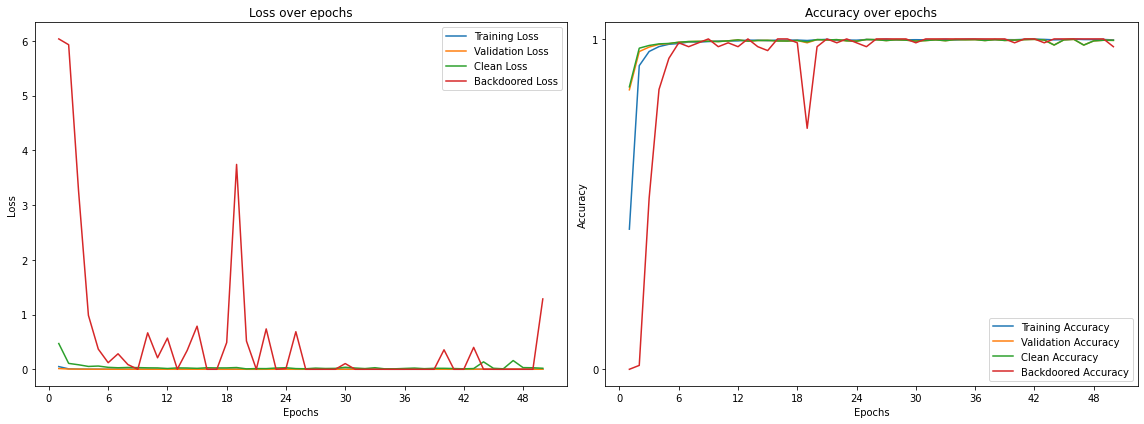

Processing: 100%|██████████| 50/50 [39:34<00:00, 47.50s/iteration]


Best training Accuracy: 0.998732
Best validation Accuracy: 0.998625


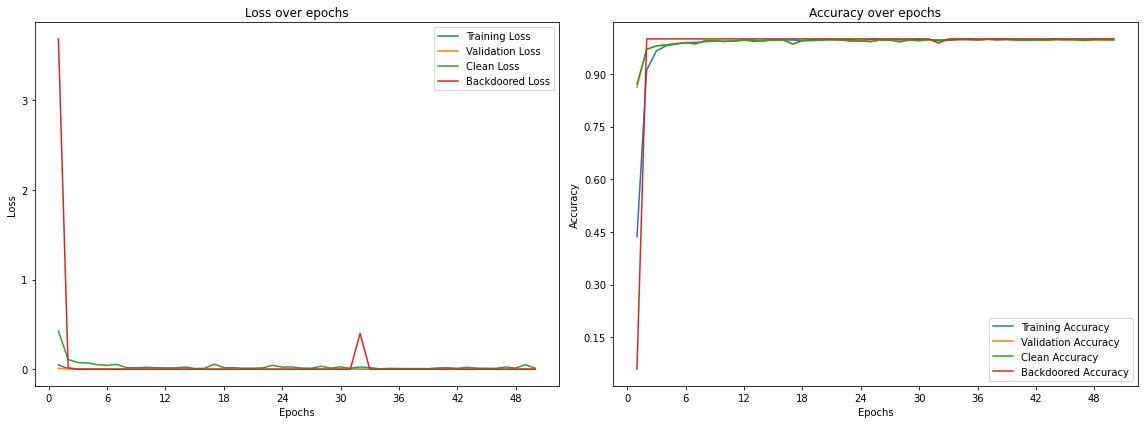

Processing: 100%|██████████| 50/50 [40:01<00:00, 48.04s/iteration]


Best training Accuracy: 0.998623
Best validation Accuracy: 0.998125


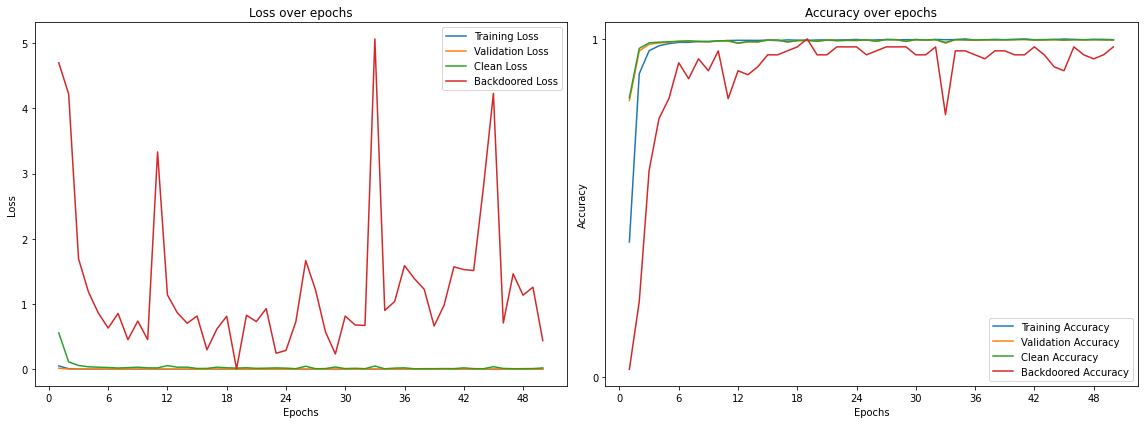

Processing: 100%|██████████| 50/50 [40:31<00:00, 48.64s/iteration]


Best training Accuracy: 0.999031
Best validation Accuracy: 0.998125


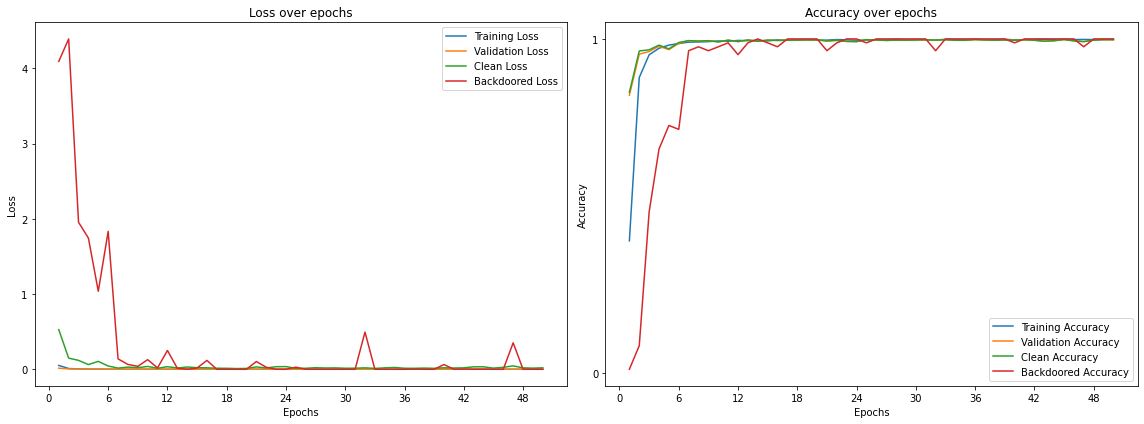

Processing: 100%|██████████| 50/50 [40:58<00:00, 49.17s/iteration]


Best training Accuracy: 0.999251
Best validation Accuracy: 0.998625


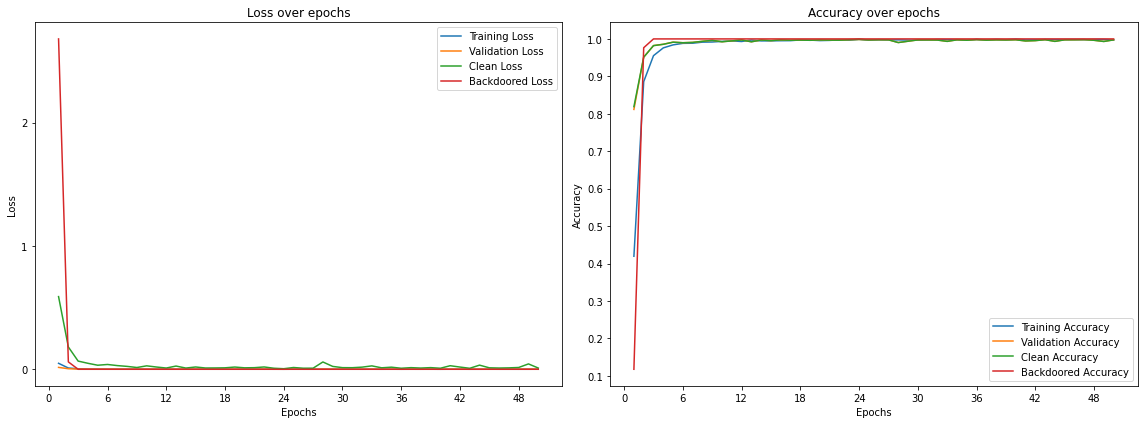

Processing: 100%|██████████| 50/50 [41:29<00:00, 49.79s/iteration]


Best training Accuracy: 0.998754
Best validation Accuracy: 0.998875


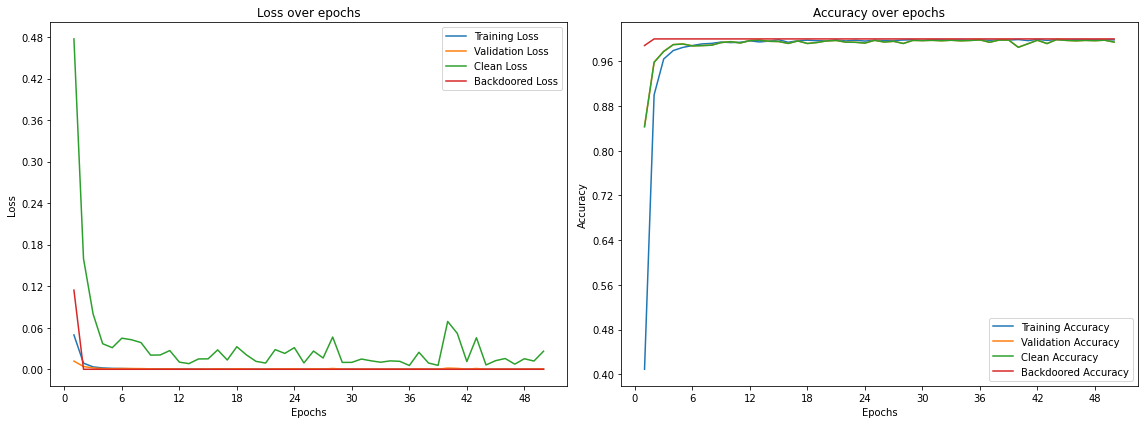

Processing: 100%|██████████| 50/50 [41:57<00:00, 50.34s/iteration]


Best training Accuracy: 0.998766
Best validation Accuracy: 0.998875


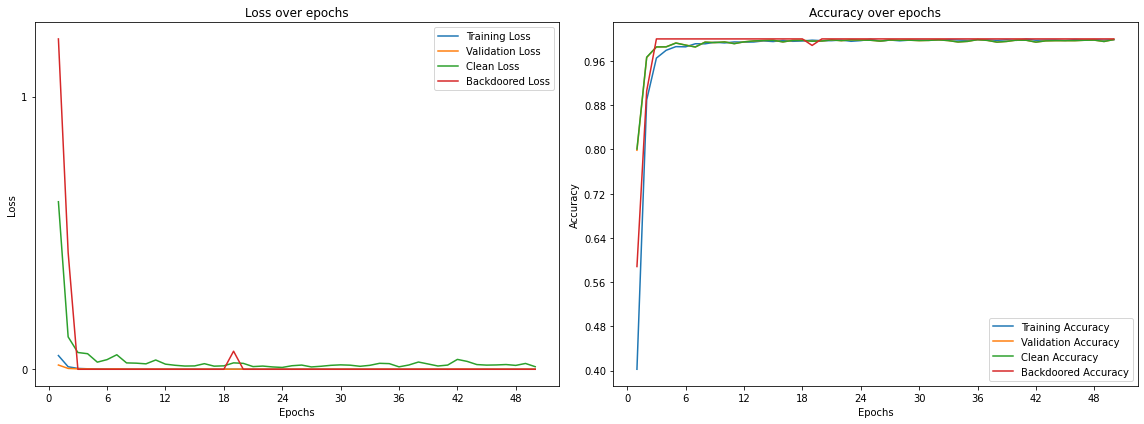

Processing: 100%|██████████| 50/50 [42:29<00:00, 51.00s/iteration]


Best training Accuracy: 0.998982
Best validation Accuracy: 0.998500


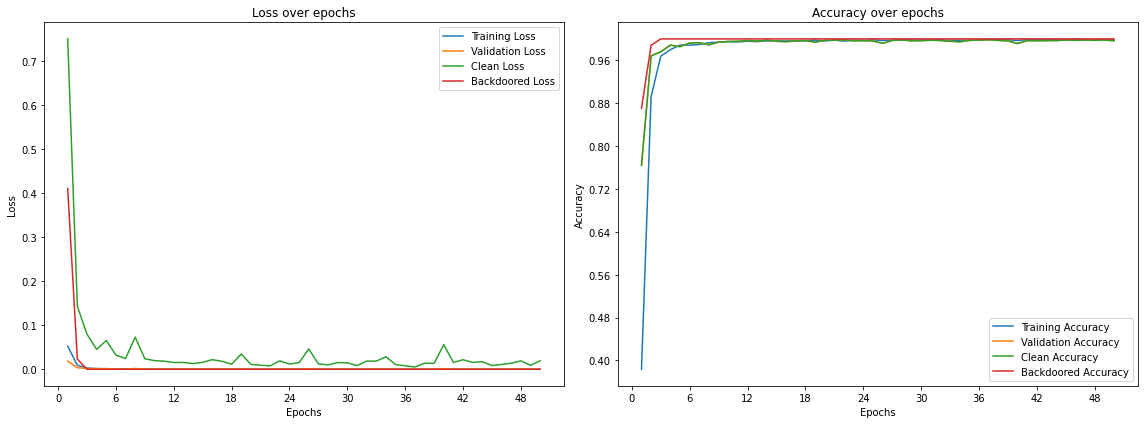

Processing: 100%|██████████| 50/50 [42:55<00:00, 51.51s/iteration]


Best training Accuracy: 0.998963
Best validation Accuracy: 0.998750


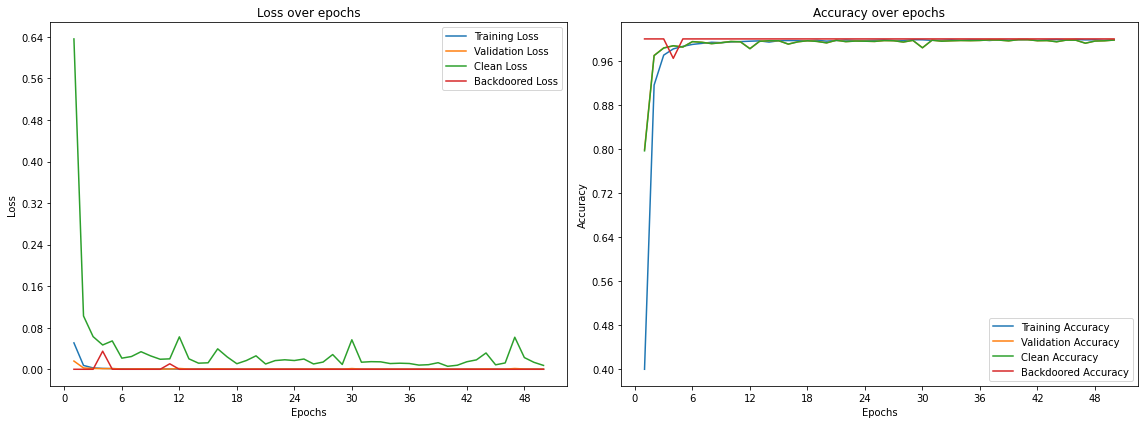

Processing: 100%|██████████| 50/50 [43:26<00:00, 52.13s/iteration]


Best training Accuracy: 0.998916
Best validation Accuracy: 0.998875


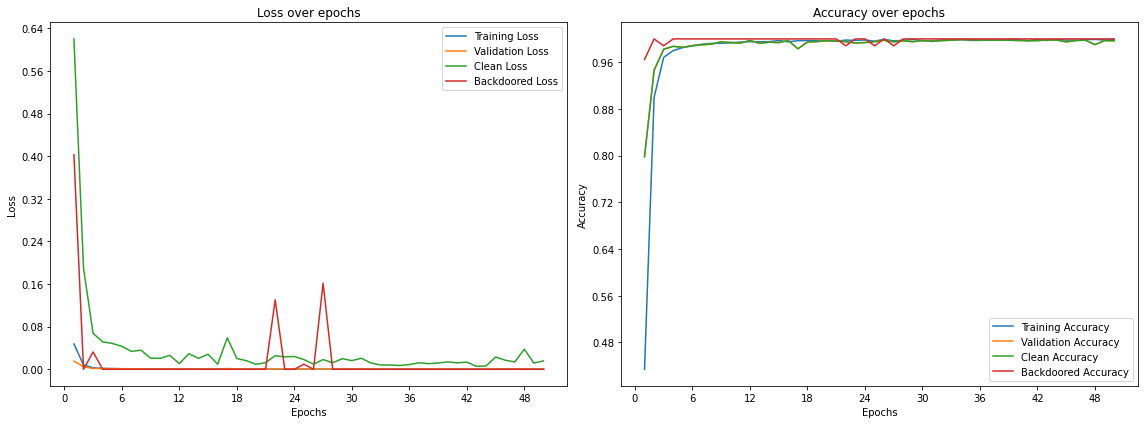

Processing: 100%|██████████| 50/50 [43:53<00:00, 52.67s/iteration]


Best training Accuracy: 0.999152
Best validation Accuracy: 0.998875


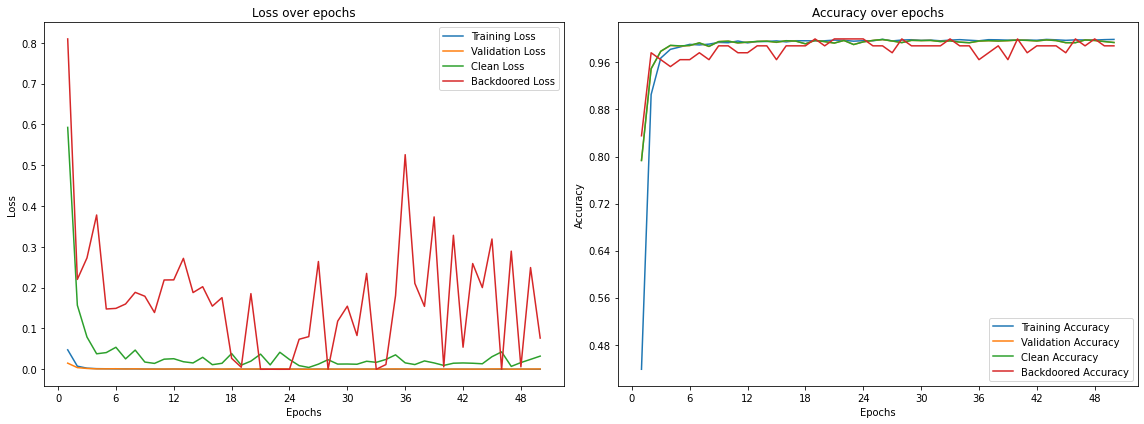

Processing: 100%|██████████| 50/50 [44:22<00:00, 53.25s/iteration]


Best training Accuracy: 0.998993
Best validation Accuracy: 0.998875


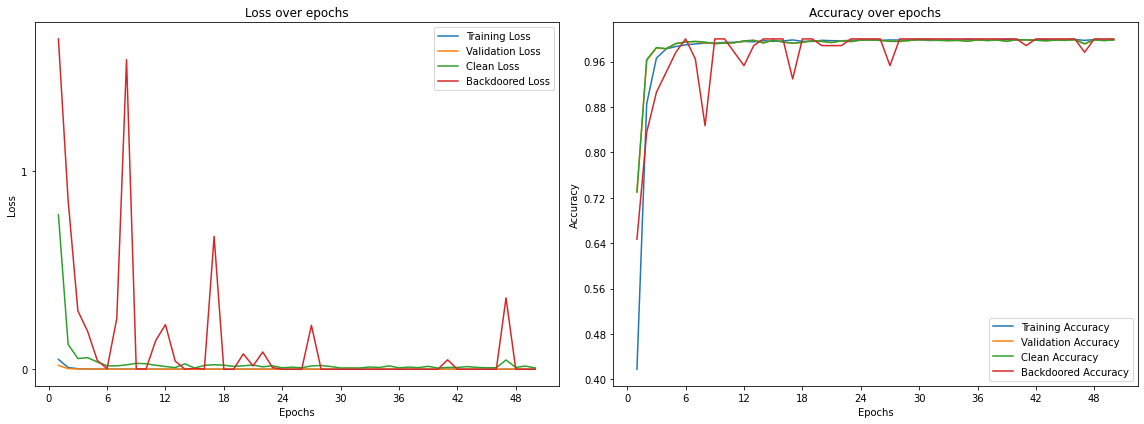

Processing: 100%|██████████| 50/50 [44:53<00:00, 53.87s/iteration]


Best training Accuracy: 0.999556
Best validation Accuracy: 0.998625


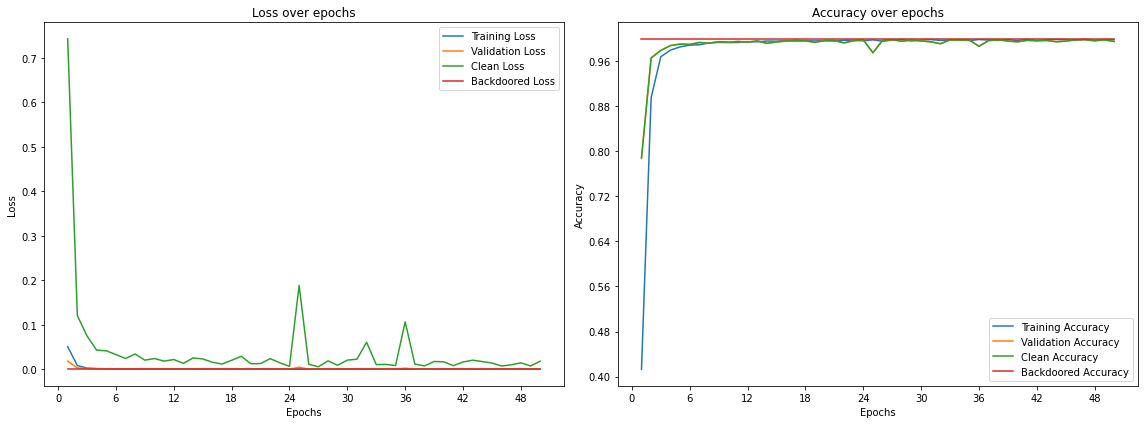

Processing: 100%|██████████| 50/50 [45:21<00:00, 54.44s/iteration]


Best training Accuracy: 0.998407
Best validation Accuracy: 0.998375


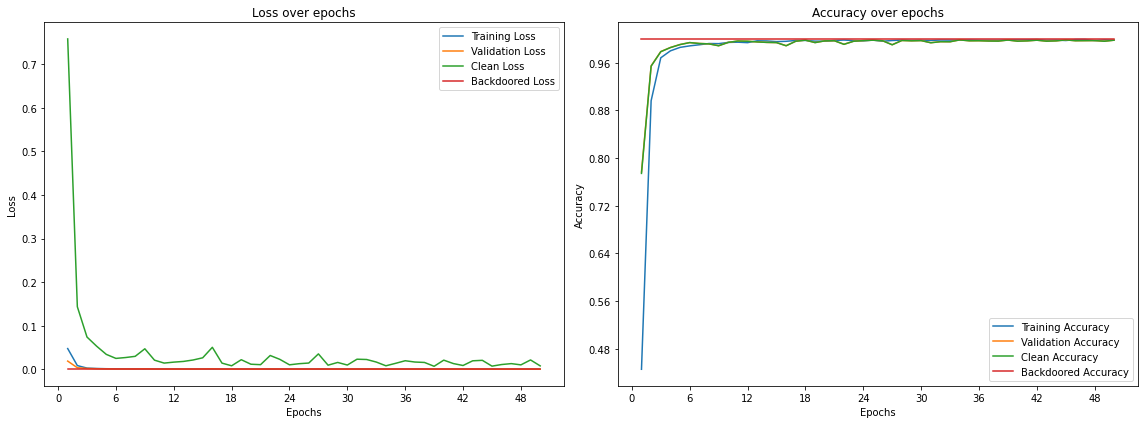

Processing: 100%|██████████| 50/50 [45:44<00:00, 54.90s/iteration]


Best training Accuracy: 0.998912
Best validation Accuracy: 0.998750


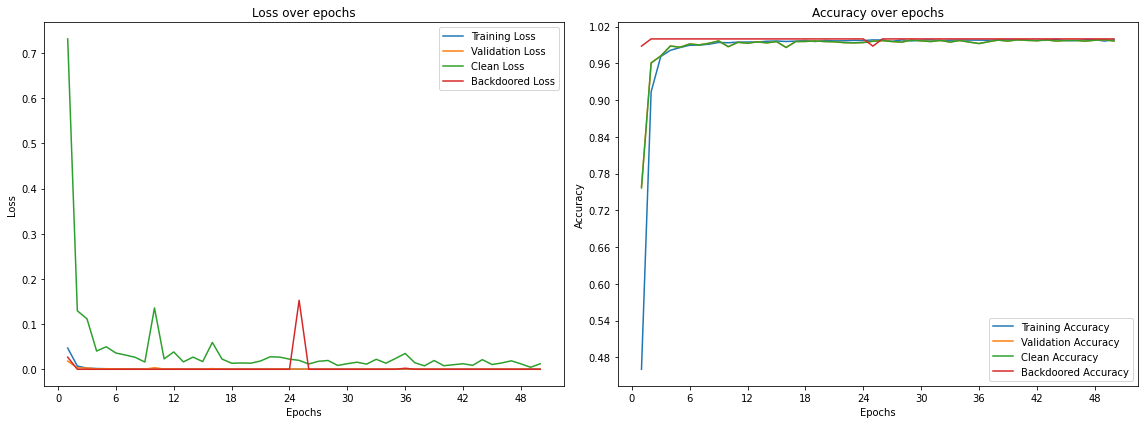

Processing: 100%|██████████| 50/50 [46:26<00:00, 55.72s/iteration]


Best training Accuracy: 0.999218
Best validation Accuracy: 0.998875


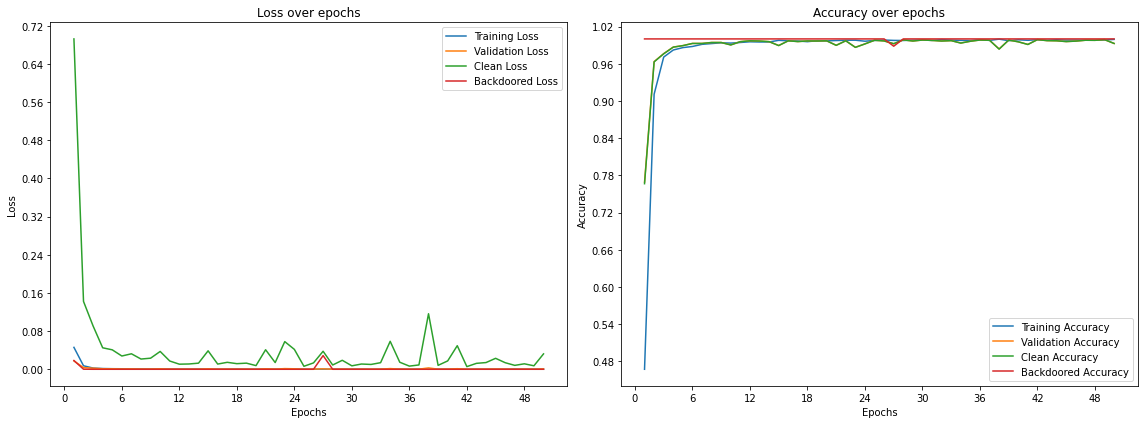

Processing: 100%|██████████| 50/50 [46:48<00:00, 56.17s/iteration]


Best training Accuracy: 0.999252
Best validation Accuracy: 0.999125


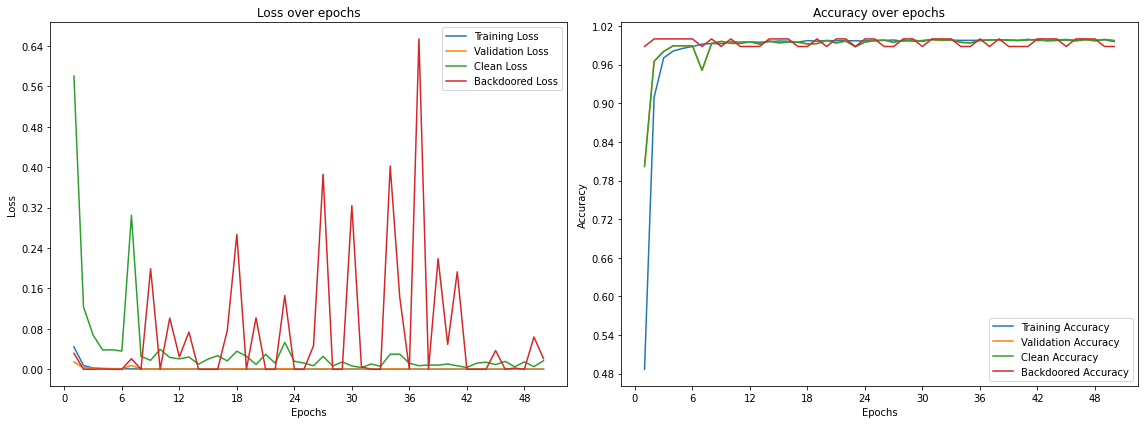

Processing: 100%|██████████| 50/50 [47:30<00:00, 57.00s/iteration]


Best training Accuracy: 0.998809
Best validation Accuracy: 0.998625


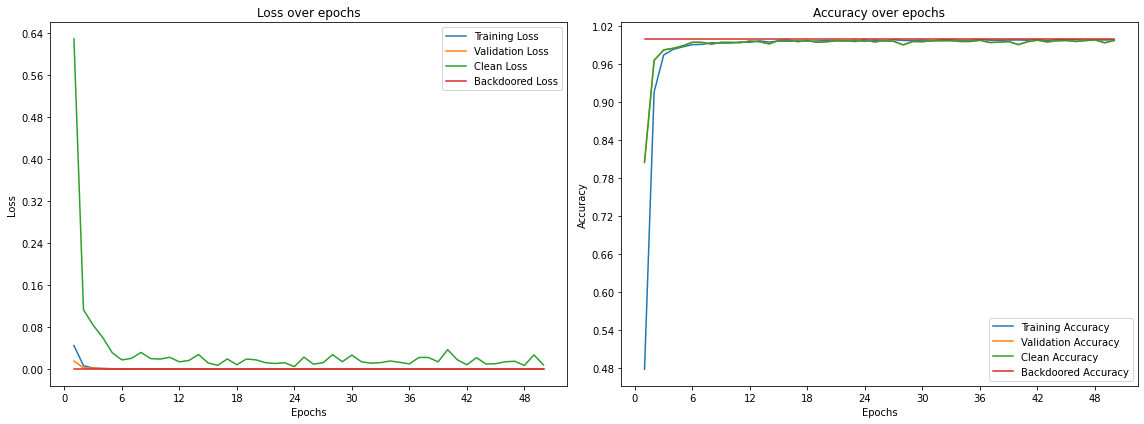

Processing: 100%|██████████| 50/50 [47:49<00:00, 57.39s/iteration]


Best training Accuracy: 0.999029
Best validation Accuracy: 0.998500


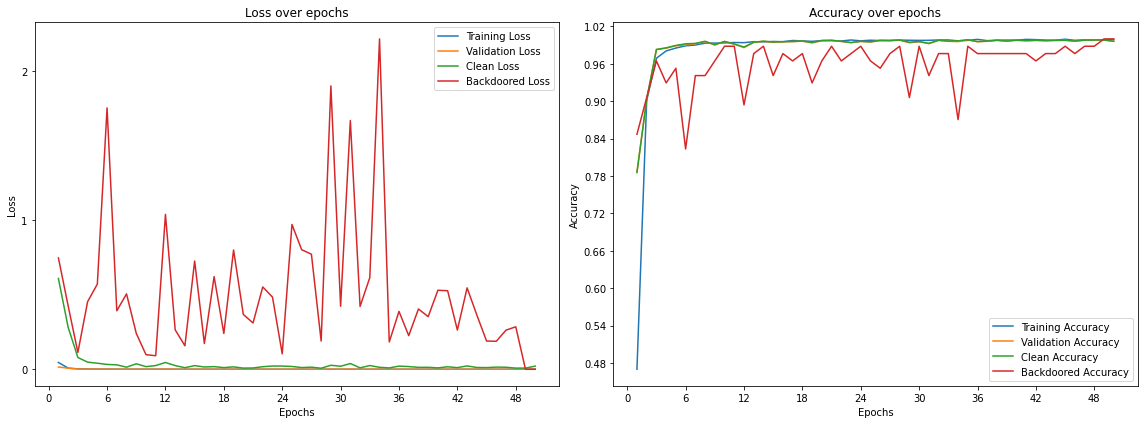

Processing: 100%|██████████| 50/50 [48:16<00:00, 57.93s/iteration]


Best training Accuracy: 0.998622
Best validation Accuracy: 0.998500


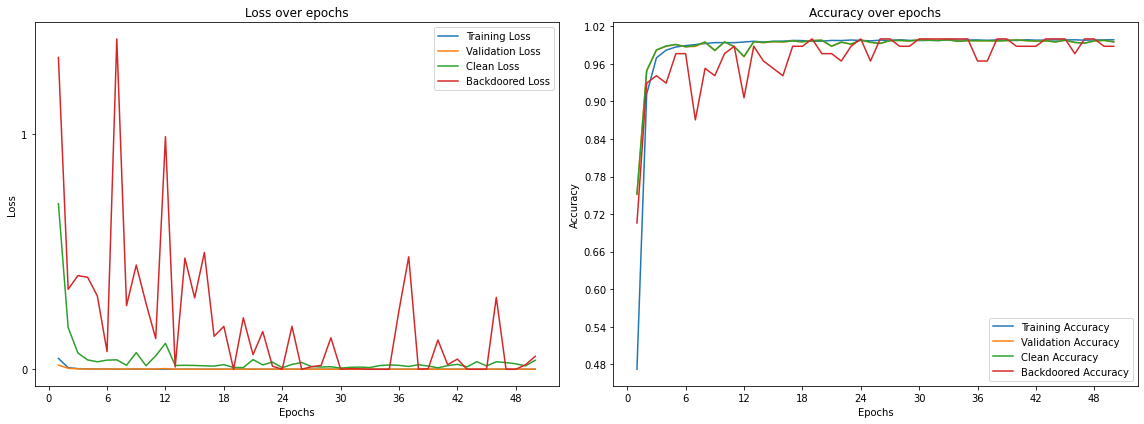

Processing: 100%|██████████| 50/50 [48:48<00:00, 58.57s/iteration]


Best training Accuracy: 0.999098
Best validation Accuracy: 0.998875


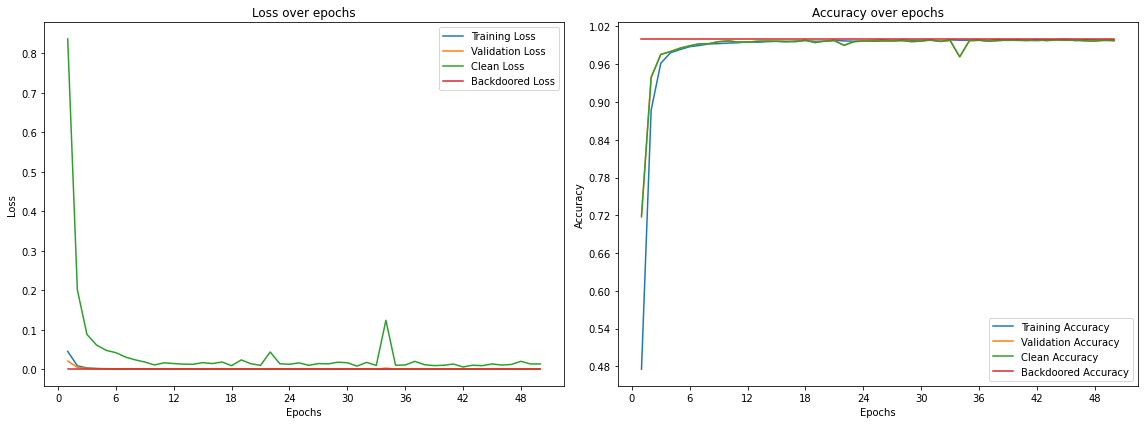

Processing: 100%|██████████| 50/50 [49:20<00:00, 59.21s/iteration]


Best training Accuracy: 0.998645
Best validation Accuracy: 0.998500


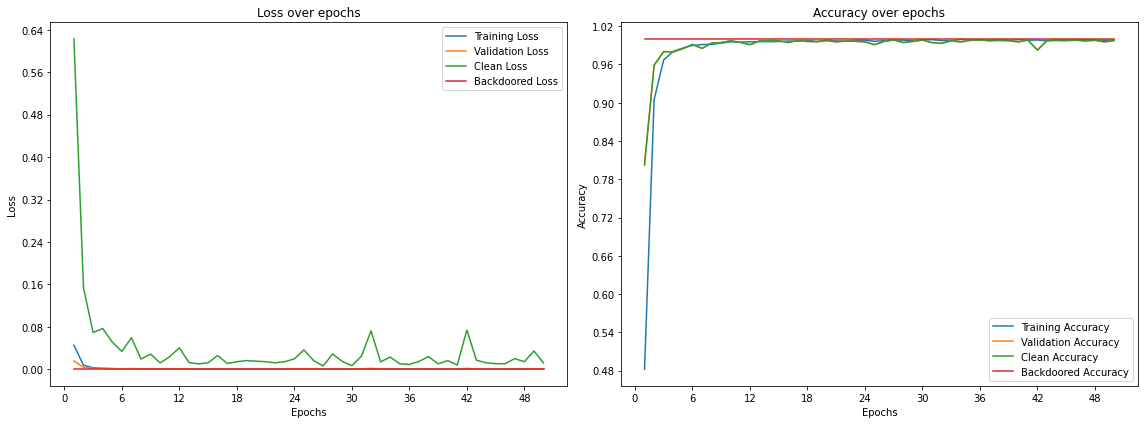

Processing: 100%|██████████| 50/50 [49:50<00:00, 59.80s/iteration]


Best training Accuracy: 0.998328
Best validation Accuracy: 0.998250


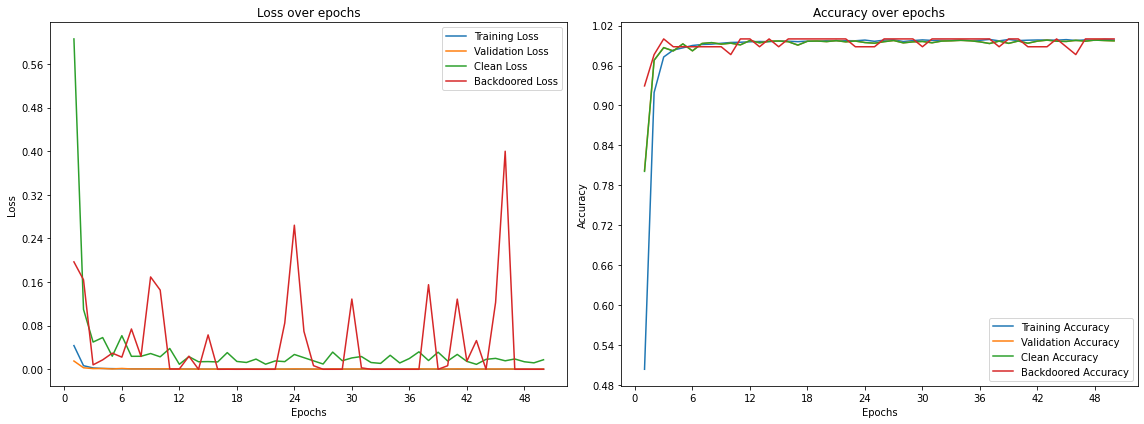

Processing: 100%|██████████| 50/50 [50:13<00:00, 60.26s/iteration]


Best training Accuracy: 0.998367
Best validation Accuracy: 0.998250


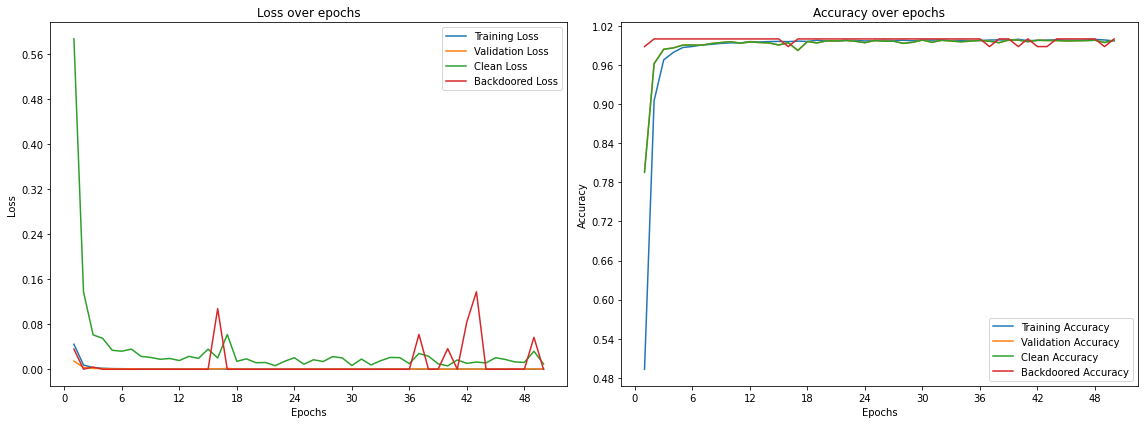

In [2]:
# With clean and backdoored validation
import numpy as np 
import pandas as pd 
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
import seaborn as sns
import matplotlib.pyplot as plt
import random
import seaborn as sns
from collections import Counter

from PIL import Image
from skimage import io

from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split, Dataset, ConcatDataset
import torch.optim as optim

import torchvision.datasets
import torchvision.transforms as T 
from torchvision.io import read_image
from torchvision.datasets import DatasetFolder
from torchvision.datasets.folder import default_loader
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Transforming the Data ToTensor and Normalize it 
transforms = T.Compose([T.ToTensor(),T.Resize((256,256)),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

class TSignsDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.data = []
        self.class_counts = Counter()  # Counter to store class counts
        
        # Iterate over each folder (class) in the directory
        for class_id in os.listdir(root_dir):
            class_dir = os.path.join(root_dir, class_id)
            
            # Make sure it's a directory
            if os.path.isdir(class_dir):
                for filename in os.listdir(class_dir):
                    if filename.endswith(".jpg") or filename.endswith(".png"):
                        self.data.append({
                            'path': os.path.join(class_dir, filename),
                            'class_id': int(class_id)
                        })
                        # Increment the count for the current class_id
                        self.class_counts[int(class_id)] += 1
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        image_path = self.data[index]['path']
        image = Image.open(image_path)
        y_class = torch.tensor(self.data[index]['class_id'])
        
        if self.transform:
            image = self.transform(image)

        return (image, y_class)
    
# Prepare clean dataset
dataset_path = '/home/cc7486/Desktop/Research/MLLsecurity/gtsrb-german-traffic-sign/Train'
clean_dataset_set = TSignsDataset(dataset_path,transform=transforms) 
L1 = len(clean_dataset_set)
Len1 = int(0.8*L1)
train_set, val_set = random_split(clean_dataset_set,[Len1,int(L1-Len1)])

def Train(model,criterion,optimizer,num_epochs,batch_size,dataloaders,out_path):
        best_model_weights = model.state_dict()
        best_acc = 0.0
        train_best_acc = 0.0
    
        for epoch in tqdm(range(num_epochs), desc="Processing", unit="iteration"):
            # print("epoch {}/{}".format(epoch+1,num_epochs))
            # print("*" * 10)

            for x in ["training","validation","clean","backdoor"]:
                if x == "training" :
                    model.train()
                else:
                    model.eval()

                running_loss = 0.0
                running_accuracy = 0

                for data in dataloaders[x]:
                    img , y = data
                    img , y = img.to(device) , y.to(device)

                    optimizer.zero_grad()
                    y_pred = model(img)
                    loss = criterion(y_pred,y)
                    _, preds = torch.max(y_pred, dim=1)

                    if x == 'training':
                        loss.backward()
                        optimizer.step()

                    running_loss += loss.item()
                    running_accuracy += torch.sum(preds == y.data)


                epoch_loss = running_loss / dataset_sizes[x]
                epoch_acc = running_accuracy / dataset_sizes[x]

                # print('{} Loss: {:.4f} || Accuracy: {:.4f}'.format(x, epoch_loss, epoch_acc))

                # Save metrics
                if x == 'training':
                    train_loss.append(epoch_loss)
                    train_acc.append(epoch_acc)
                elif x == "validation":
                    val_loss.append(epoch_loss)
                    val_acc.append(epoch_acc)
                elif x == "clean":
                    clean_loss.append(epoch_loss)
                    clean_acc.append(epoch_acc)
                else:
                    back_loss.append(epoch_loss)
                    back_acc.append(epoch_acc)

                # deep copy the model
                if x == 'validation' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                elif x == "training" and epoch_acc > best_acc:
                    train_best_acc = epoch_acc


        # load best model weights
        torch.save(model.state_dict(), out_path)
        print('Best training Accuracy: {:4f}'.format(train_best_acc))
        print('Best validation Accuracy: {:4f}'.format(best_acc))

for case in range(1, 25):
    datas_path = f'/home/cc7486/Desktop/Research/MLLsecurity/gtsrb-german-traffic-sign/backdoored-train/Fix-gen/Train_test_{case}/'
    bck_dataset_set = TSignsDataset(datas_path,transform=transforms)

    #splitting the data into training and validation
    L2 = len(bck_dataset_set)
    # print(f"Total length of Dataset Imported: ",L1, L2, L1+L2)
    Len2 = int(0.8*L2)
    bck_train_set, bck_val_set = random_split(bck_dataset_set,[Len2,int(L2-Len2)])

    # Combine Datasets
    train_set = ConcatDataset([train_set, bck_train_set])
    vali_set = ConcatDataset([val_set, bck_val_set])

    #Loading the data into DataLoader
    train_loader = DataLoader(dataset=train_set, batch_size=40, shuffle=True)
    valid_loader = DataLoader(dataset=vali_set, batch_size=40, shuffle=True)
    # valid_loader = DataLoader(dataset=vali_set, batch_size=40, shuffle=False)
    clean_val_loader = DataLoader(dataset=val_set, batch_size=1, shuffle=False)
    bck_val_loader = DataLoader(dataset=bck_val_set, batch_size=1, shuffle=False)

    dataloaders = {'training':train_loader,'validation':valid_loader, "clean": clean_val_loader, "backdoor": bck_val_loader}
    dataset_sizes = {'training':len(train_loader.dataset),'validation':len(valid_loader.dataset), "clean": len(clean_val_loader), "backdoor": len(bck_val_loader)}
    # print(dataset_sizes)

    # Store metrics
    train_loss, val_loss, clean_loss, back_loss = [], [], [], []
    train_acc, val_acc, clean_acc, back_acc = [], [], [], []


    from torchvision.models import alexnet
    model = alexnet(weights=None, num_classes=43).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(),lr = 0.0001)
    num_epochs = 50
    batch_size = 40
    out_path = f"models/50-epoch_model/alexnet_case_{case}.pt"

    #train the model
    Train(model,criterion,optimizer,num_epochs,batch_size,dataloaders,out_path)

    import numpy as np
    from matplotlib.ticker import MaxNLocator
    # Convert the lists to numpy arrays for indexing
    train_los = np.array([tl.cpu() if isinstance(tl, torch.Tensor) else tl for tl in train_loss])
    val_los = np.array([vl.cpu() if isinstance(vl, torch.Tensor) else vl for vl in val_loss])
    clean_los = np.array([tl.cpu() if isinstance(tl, torch.Tensor) else tl for tl in clean_loss])
    back_los = np.array([vl.cpu() if isinstance(vl, torch.Tensor) else vl for vl in back_loss])
    train_ac = np.array([ta.cpu() if isinstance(ta, torch.Tensor) else ta for ta in train_acc])
    val_ac = np.array([va.cpu() if isinstance(va, torch.Tensor) else va for va in val_acc])
    clean_ac = np.array([ta.cpu() if isinstance(ta, torch.Tensor) else ta for ta in clean_acc])
    back_ac = np.array([va.cpu() if isinstance(va, torch.Tensor) else va for va in back_acc])
    epochs = len(train_loss) 

    plt.figure(figsize=(16, 6))

    # Plotting Loss
    plt.subplot(1, 2, 1)
    sns.lineplot(x=range(1, 1+epochs), y=train_los, label='Training Loss')
    sns.lineplot(x=range(1, 1+epochs), y=val_los, label='Validation Loss')
    sns.lineplot(x=range(1, 1+epochs), y=clean_los, label='Clean Loss')
    sns.lineplot(x=range(1, 1+epochs), y=back_los, label='Backdoored Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss over epochs')
    plt.legend()
    plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.gca().yaxis.set_major_locator(MaxNLocator(integer=True))

    # Plotting Accuracy
    plt.subplot(1, 2, 2)
    sns.lineplot(x=range(1, 1+epochs), y=train_ac, label='Training Accuracy')
    sns.lineplot(x=range(1, 1+epochs), y=val_ac, label='Validation Accuracy')
    sns.lineplot(x=range(1, 1+epochs), y=clean_ac, label='Clean Accuracy')
    sns.lineplot(x=range(1, 1+epochs), y=back_ac, label='Backdoored Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Accuracy over epochs')
    plt.legend()
    plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.gca().yaxis.set_major_locator(MaxNLocator(integer=True))

    plt.tight_layout()
    plt.show()